# The Impact of Gun Laws on Homicide Rates Internationally
The [United Nations Office on Drugs and Crimes](https://dataunodc.un.org/GSH_app) maintains a database of information on homicide rates by country around the world, and provides separate counts for homicides by firearm. The objectives here will be to compare those rates with gun ownership rates around the world, along with their gun laws. In this way, the goal is to determine the effectiveness of gun laws around the world.

## United Nations Data
The portal to access UN data requires manual filtering, but a temporary custom link is generated for downloading the data to csv. Here, the filters were set to download **Homicide Counts & Rates,** as well as **Homicide Counts by Firearm,** for 2015. Rates by firearm were unavailable. This was chosen as the most recent year for which a viable sample size was available.

In [1]:
import pandas as pd

# url = 'https://unodc.shinyapps.io/GSH_App/_w_089fa1ab/session/070e4d675d45054c1ed1984a6a1af892/download/download_country_data?w=089fa1ab'
# raw_df = pd.read_csv(url)
# raw_df.to_csv('international_data/homicide_country_data.csv')

raw_df = pd.read_csv('international_data/homicide_country_data.csv')
raw_df[raw_df['Country'] == 'United States of America']

,Country,Region,Subregion,Indicator,2015
684,United States of America,Americas,Northern America,Homicide Total Count,15883.0
685,United States of America,Americas,Northern America,Homicide Rate,5.0
686,United States of America,Americas,Northern America,Homicide by Firearms,9814.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

df_dict = {'Country':[], 'Homicides':[], 'Firearm Homicides':[]}

for country in raw_df['Country'].unique():
    df_dict['Country'].append(country)
    df_dict['Homicides'].append(raw_df[(raw_df['Indicator']=='Homicide Total Count') & (raw_df['Country']==country)]['2015'].values[0])
    df_dict['Firearm Homicides'].append(raw_df[(raw_df['Indicator']=='Homicide by Firearms') & (raw_df['Country']==country)]['2015'].values[0])
    
df = pd.DataFrame.from_dict(df_dict).dropna()
df = df.set_index('Country')
df.head()

,Homicides,Firearm Homicides
Country,,
Albania,82.0,46.0
Algeria,542.0,77.0
Andorra,0.0,0.0
Argentina,2837.0,1622.0
Armenia,75.0,26.0


## Population Data
Because we are reliant on counts rather than age- and population-adjusted rates, population data must be added separately. This data was downloaded in a csv from [The World Bank](https://data.worldbank.org/indicator/sp.pop.totl?end=2015&start=2015).

In [3]:
population = pd.read_csv('international_data/API_SP.POP.TOTL_DS2_en_csv_v2_103676.csv', skiprows=1, header=1, usecols=['Country Name', '2015'])
population = population.set_index('Country Name')
population.head()

,2015
Country Name,
Aruba,104341.0
Afghanistan,34413603.0
Angola,27884381.0
Albania,2880703.0
Andorra,78011.0


### Name Mapping
Because various naming conventions were used for nations across datasets, a mapping file was manually created to link sources together. This file was saved within the International Data folder as country_name_map.xlsx.

In [4]:
# Import name map and set population country name as index
name_map = pd.read_excel('international_data/country_name_map.xlsx').set_index('Country (population)')

# Join population data with naming conventions and use naming convention from homicide rate data
name_map = name_map.join(population).reset_index()
name_map = name_map.rename(columns = {'Country (Homicide Rate)': 'Country'})[['Country', '2015']].set_index('Country')
name_map.head()

# Join population and homicide data
pop_df = df.join(name_map['2015'])
pop_df = pop_df.rename(columns={'2015': 'Population'})
pop_df.head()

,Homicides,Firearm Homicides,Population
Country,,,
Albania,82.0,46.0,2880703.0
Algeria,542.0,77.0,39728025.0
Andorra,0.0,0.0,78011.0
Argentina,2837.0,1622.0,43131966.0
Armenia,75.0,26.0,2925553.0


In [5]:
# Import name map and set population country name as index
name_map = pd.read_excel('international_data/country_name_map.xlsx').set_index('Country (population)')

# Join population data with naming conventions and use naming convention from homicide rate data
name_map = name_map.join(population).reset_index()
name_map = name_map.rename(columns = {'Country (Homicide Rate)': 'Country'})[['Country', '2015']].set_index('Country')
name_map.head()

,2015
Country,
Aruba,104341.0
Afghanistan,34413603.0
Angola,27884381.0
Albania,2880703.0
Andorra,78011.0


In [6]:
# Join population and homicide data
pop_df = df.join(name_map['2015'])
pop_df = pop_df.rename(columns={'2015': 'Population'})
pop_df.head()

,Homicides,Firearm Homicides,Population
Country,,,
Albania,82.0,46.0,2880703.0
Algeria,542.0,77.0,39728025.0
Andorra,0.0,0.0,78011.0
Argentina,2837.0,1622.0,43131966.0
Armenia,75.0,26.0,2925553.0


### Rate Calculations
Use population data and homicide counts to calculate rate. These will not be population or age adjusted, which will likely result in more variation in the results. Should be taken into consideration when interpreting results later.

In [7]:
pop_df['Homicide Rate'] = 1000000 * pop_df['Homicides'] / pop_df['Population']
pop_df['Firearm Homicide Rate'] = 1000000 * pop_df['Firearm Homicides'] / pop_df['Population']
pop_df = pop_df[['Homicide Rate', 'Firearm Homicide Rate']]
pop_df = pop_df.dropna()
pop_df.head()

,Homicide Rate,Firearm Homicide Rate
Country,,
Albania,28.465274,15.968324
Algeria,13.642762,1.938178
Andorra,0.000000,0.000000
Argentina,65.774883,37.605520
Armenia,25.636179,8.887209


In [8]:
pop_df.describe()

,Homicide Rate,Firearm Homicide Rate
count,66.000000,66.000000
mean,85.010017,51.859797
std,161.220947,131.148484
min,0.000000,0.000000
25%,10.365572,1.001350
50%,27.894739,3.187299
75%,73.497768,34.239536
max,1052.311386,875.239758


## Guns Ownership Rates
This data is scraped from [Wikipedia](https://en.wikipedia.org/wiki/Estimated_number_of_civilian_guns_per_capita_by_country) for simplicity, though the content itself has been verified against the source data in the [Small Arms Survey](http://www.smallarmssurvey.org/weapons-and-markets/tools/global-firearms-holdings.html). Ownership rates are defined as the number of civilian guns held per 100 persons in the population.

In [9]:
from bs4 import BeautifulSoup
import requests

url = 'https://en.wikipedia.org/wiki/Estimated_number_of_civilian_guns_per_capita_by_country'

tables = []
ownership_rates = []

#Make a get request to retrieve the page
html_page = requests.get(url) 

#Pass the page contents to beautiful soup for parsing
soup = BeautifulSoup(html_page.content, 'html.parser') 

# States use the 'strong' tag
tables = soup.find_all('table')

In [10]:
# Search for <a> tags in table; countries begin with record 5
# Notes are included in the tables, but should be omitted
a_tags = tables[0].find_all('a')
countries = [tag.text for tag in a_tags[5:] if 'note' not in tag.text]
len(countries)

230

In [11]:
# Ownership rates by country are the 2nd <td> tag in each row of 11 columns
ownership_rates = []
for i in range(230):
    ownership_rates.append(float(tables[0].find_all('td')[i * 11 + 2].text[:-1]))
len(ownership_rates)

230

### Manual Edit
Ireland, England, & Scotland are represented independently in gun ownership tables, but results are consolidated everywhere else. A weighted average of the ownership rates are combined with weightings based on population levels so that these particular results can be incuded in the final dataset.

In [12]:
# Save ownership rates and countries to dataframe
gun_ownership = pd.DataFrame.from_dict({'Country': countries, 'Ownership Rate': ownership_rates})

# Manually calculate values for UK divisions
scotland = [5.6, 5436000] #[Ownership rate, population]
england = [4.6, 58877000]
ireland = [11, 1873000]
UK = [scotland, england, ireland]

# Add populations and calculate weighted sum of ownership rates
UK_pop = np.sum([region[1] for region in UK])
UK_rate = np.round(np.sum([region[0] * region[1]/UK_pop for region in UK]), 1)

# Append results to dataframe & display results
gun_ownership=gun_ownership.append({'Country':'United Kingdom of Great Britain and Northern Ireland', 'Ownership Rate':UK_rate}, ignore_index=True)
gun_ownership.to_csv('international_data/gun_ownership.csv')
gun_ownership = gun_ownership.set_index('Country')
gun_ownership

,Ownership Rate
Country,
United States,120.5
Falkland Islands,62.1
Yemen,52.8
New Caledonia,42.5
Montenegro,39.1
Serbia,39.1
Canada,34.7
Uruguay,34.7
Cyprus,34.0


# Join Ownership Rates with Primary Dataset
Use name map to join data with primary dataset.

In [13]:
# Import name map and set population country name as index
name_map = pd.read_excel('international_data/country_name_map.xlsx').set_index('Country (Ownership)')

# Join population data with naming conventions and use naming convention from homicide rate data
name_map = name_map.join(gun_ownership).reset_index()
name_map = name_map.rename(columns = {'Country (Homicide Rate)': 'Country'})[['Country', 'Ownership Rate']].set_index('Country')
name_map.head()

# Join population and homicide data
owner_df = pop_df.join(name_map['Ownership Rate'])
owner_df.head()

,Homicide Rate,Firearm Homicide Rate,Ownership Rate
Country,,,
Albania,28.465274,15.968324,12.0
Algeria,13.642762,1.938178,2.1
Andorra,0.000000,0.000000,14.1
Argentina,65.774883,37.605520,7.4
Armenia,25.636179,8.887209,6.1


## Gun Laws by Nation
The only collection that could be found which allowed for a practical comparison of laws between countries was [Wikipedia](https://en.wikipedia.org/wiki/Overview_of_gun_laws_by_nation). With over 300 sources on this particular page, it was impractical to check each source one at a time, so a spot check on 5 different links were validated. While it is expected that this will introduce a fair amount of uncertainty, it should still suffice for investigative rather than conclusive purposes. The results herein should not be accepted in silo, but may achieve more value when corroborated with other data.

The site contains a table of 10 features of gun laws between countries, each of which are color coded based on relative strength of the laws in that country for that specific topic. Each of these colors was assigned a value, with 1 being the least restrictive, and 4 being the most restrictive. The mean of these features for each country was calculated to get the overall score. This is consistent with the aggregation of data, particularly with regard to the United States: all categories were set to level 2 due to variation between states, which itself is a form of uncertainty.

Later iterations of this analysis would allow Giffords data to approximate values for the US.

In [14]:
# Scrape data from Wikipedia
url = 'https://en.wikipedia.org/wiki/Overview_of_gun_laws_by_nation'

#Make a get request to retrieve the page
html_page = requests.get(url) 

#Pass the page contents to beautiful soup for parsing
soup = BeautifulSoup(html_page.content, 'html.parser') 

# States use the 'strong' tag
tables = soup.find_all('table', class_='wikitable sortable')

In [64]:
# Create dictionary with table headers as keys
table = tables[0]
gun_laws = {'Country':[]}

for header in table.find_all('th'):
    gun_laws[header.text.strip()] = []

# Get rid of first blank header cell
del gun_laws['']
gun_laws

{'Country': [],
 'Private citizens': [],
 'Personal protection': [],
 'Open carry': [],
 'Concealed carry': [],
 'Carry without permit': [],
 'Fully automatic firearms': [],
 'Unlimited magazine': [],
 'Free of checks': [],
 'Free of registration': [],
 'Max penalty (years)': []}

In [65]:
gun_law_keys = list(gun_laws.keys())

# Create dictionary to translate background color codes to rankings
# 1 is least restrictive, 4 is most restrictive
codes = {'#9F9': 1, '#ffff90': 2, '#F99': 3, 'rgb(220, 36, 31)': 4}

# Table is 11 columns wide and 87 rows deep
# Final column sometimes has merged rows and messes up order
# Can be identified if first column of new row contains yes or no
# Wild variable incremented to adjust whenever this is encountered
wild = 0
for j in range(0, 87):
    for i in range(0, 11):
        
        # Get text for country name in first column
        if i == 0:
            country = table.find_all('td')[11*j+i-wild].text.split('[')[0].strip()
            if country.split()[0] in ['Yes', 'No']:
                wild += 1
                country = table.find_all('td')[11*j+i-wild].text.split('[')[0].strip()
                country = country[:-5] if country[-4:] == '(EU)' else country
                gun_laws[gun_law_keys[i]].append(country)
            else:
                country = country[:-5] if country[-4:] == '(EU)' else country
                gun_laws[gun_law_keys[i]].append(country)
        
        # Get background color for all other columns
        else:
            try:
                code = table.find_all('td')[11*j+i-wild]['style'].split(':')[1].strip().split(';')[0]
                gun_laws[gun_law_keys[i]].append(codes[code])
            except:
                gun_laws[gun_law_keys[i]].append(None)

# Create dataframe; all null values are set to median value.
# 4 only occurs in last column for penalty strictness - not considered in median calculation
gun_laws_df = pd.DataFrame.from_dict(gun_laws)
# gun_laws_df = gun_laws_df.T.fillna(gun_laws_df.mean(axis=1)).T.set_index('Country')
gun_laws_df = gun_laws_df.fillna(2).set_index('Country')
for col in gun_laws_df.columns:
    gun_laws_df[col] = gun_laws_df[col].astype('float')
gun_laws_df.head()

,Private citizens,Personal protection,Open carry,Concealed carry,Carry without permit,Fully automatic firearms,Unlimited magazine,Free of checks,Free of registration,Max penalty (years)
Country,,,,,,,,,,
Argentina,1.0,1.0,1.0,2.0,3.0,3.0,2.0,1.0,2.0,3.0
Australia,2.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,4.0
Austria,1.0,1.0,2.0,2.0,3.0,3.0,1.0,2.0,2.0,2.0
Bosnia and Herzegovina,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0
Botswana,3.0,3.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0


In [66]:
# Strength of laws calculate as mean of row values
gun_laws_df['Overall Law Score'] = gun_laws_df.mean(axis=1)
gun_laws_df.to_csv('international_data/gun_laws.csv')
gun_laws_df.sort_values(by='Overall Law Score').head()

,Private citizens,Personal protection,Open carry,Concealed carry,Carry without permit,Fully automatic firearms,Unlimited magazine,Free of checks,Free of registration,Max penalty (years),Overall Law Score
Country,,,,,,,,,,,
Pakistan,1.0,1.0,1.0,1.0,2.0,3.0,1.0,3.0,3.0,2.0,1.8
Argentina,1.0,1.0,1.0,2.0,3.0,3.0,2.0,1.0,2.0,3.0,1.9
Austria,1.0,1.0,2.0,2.0,3.0,3.0,1.0,2.0,2.0,2.0,1.9
Poland,1.0,2.0,3.0,2.0,2.0,1.0,1.0,2.0,2.0,3.0,1.9
Iraq,1.0,1.0,2.0,2.0,2.0,1.0,2.0,3.0,3.0,2.0,1.9


In [67]:
gun_laws_df.shape

(87, 11)

### Map Country Names

In [68]:
# Import name map and set population country name as index
name_map = pd.read_excel('international_data/country_name_map.xlsx').set_index('Country (Laws)')

# Join population data with naming conventions and use naming convention from homicide rate data
name_map = name_map.join(gun_laws_df).reset_index()
name_map = name_map.rename(columns = {'Country (Homicide Rate)': 'Country'})[list(gun_laws_df.columns) + ['Country']].set_index('Country')
name_map.head()

# Join population and homicide data
gun_law_df = owner_df.join(name_map).dropna()
gun_law_df.head()

,Homicide Rate,Firearm Homicide Rate,Ownership Rate,Private citizens,Personal protection,Open carry,Concealed carry,Carry without permit,Fully automatic firearms,Unlimited magazine,Free of checks,Free of registration,Max penalty (years),Overall Law Score
Country,,,,,,,,,,,,,,
Argentina,65.774883,37.605520,7.4,1.0,1.0,1.0,2.0,3.0,3.0,2.0,1.0,2.0,3.0,1.9
Australia,9.909307,1.343635,14.5,2.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,4.0,2.9
Austria,5.322411,0.925637,30.0,1.0,1.0,2.0,2.0,3.0,3.0,1.0,2.0,2.0,2.0,1.9
Bosnia and Herzegovina,16.621172,9.331184,31.2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,2.2
Brazil,285.902549,205.480689,8.3,2.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,2.8


In [69]:
new_col_names = {}

for col in gun_law_df.columns:
    new_col = col.replace('(', '').title()
    new_col = new_col.replace(')', '')
    new_col = new_col.replace(' ', '_')
    new_col_names[col] = new_col
    
new_col_names

clean_df = gun_law_df.rename(columns=new_col_names)
print(f'Shape: {clean_df.shape}')
clean_df.head()

Shape: (38, 14)


,Homicide_Rate,Firearm_Homicide_Rate,Ownership_Rate,Private_Citizens,Personal_Protection,Open_Carry,Concealed_Carry,Carry_Without_Permit,Fully_Automatic_Firearms,Unlimited_Magazine,Free_Of_Checks,Free_Of_Registration,Max_Penalty_Years,Overall_Law_Score
Country,,,,,,,,,,,,,,
Argentina,65.774883,37.605520,7.4,1.0,1.0,1.0,2.0,3.0,3.0,2.0,1.0,2.0,3.0,1.9
Australia,9.909307,1.343635,14.5,2.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,4.0,2.9
Austria,5.322411,0.925637,30.0,1.0,1.0,2.0,2.0,3.0,3.0,1.0,2.0,2.0,2.0,1.9
Bosnia and Herzegovina,16.621172,9.331184,31.2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,2.2
Brazil,285.902549,205.480689,8.3,2.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,2.8


## Data Exploration

In [70]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38 entries, Argentina to Uruguay
Data columns (total 14 columns):
Homicide_Rate               38 non-null float64
Firearm_Homicide_Rate       38 non-null float64
Ownership_Rate              38 non-null float64
Private_Citizens            38 non-null float64
Personal_Protection         38 non-null float64
Open_Carry                  38 non-null float64
Concealed_Carry             38 non-null float64
Carry_Without_Permit        38 non-null float64
Fully_Automatic_Firearms    38 non-null float64
Unlimited_Magazine          38 non-null float64
Free_Of_Checks              38 non-null float64
Free_Of_Registration        38 non-null float64
Max_Penalty_Years           38 non-null float64
Overall_Law_Score           38 non-null float64
dtypes: float64(14)
memory usage: 4.5+ KB


In [71]:
clean_df.describe()

,Homicide_Rate,Firearm_Homicide_Rate,Ownership_Rate,Private_Citizens,Personal_Protection,Open_Carry,Concealed_Carry,Carry_Without_Permit,Fully_Automatic_Firearms,Unlimited_Magazine,Free_Of_Checks,Free_Of_Registration,Max_Penalty_Years,Overall_Law_Score
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,61.636956,38.187258,19.352632,1.552632,2.184211,2.657895,2.342105,2.868421,2.631579,1.894737,2.842105,2.842105,2.631579,2.444737
std,118.686238,92.019234,20.599157,0.554947,0.833594,0.582461,0.745303,0.342570,0.674679,0.648886,0.436591,0.369537,0.633355,0.317675
min,2.529358,0.000000,0.200000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.900000
25%,8.848402,0.974515,7.600000,1.000000,1.250000,2.000000,2.000000,3.000000,2.250000,1.250000,3.000000,3.000000,2.000000,2.200000
50%,14.825136,2.152010,13.650000,2.000000,2.000000,3.000000,2.500000,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,2.500000
75%,45.824069,15.505115,29.575000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,2.700000
max,564.912482,409.967567,120.500000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,3.000000


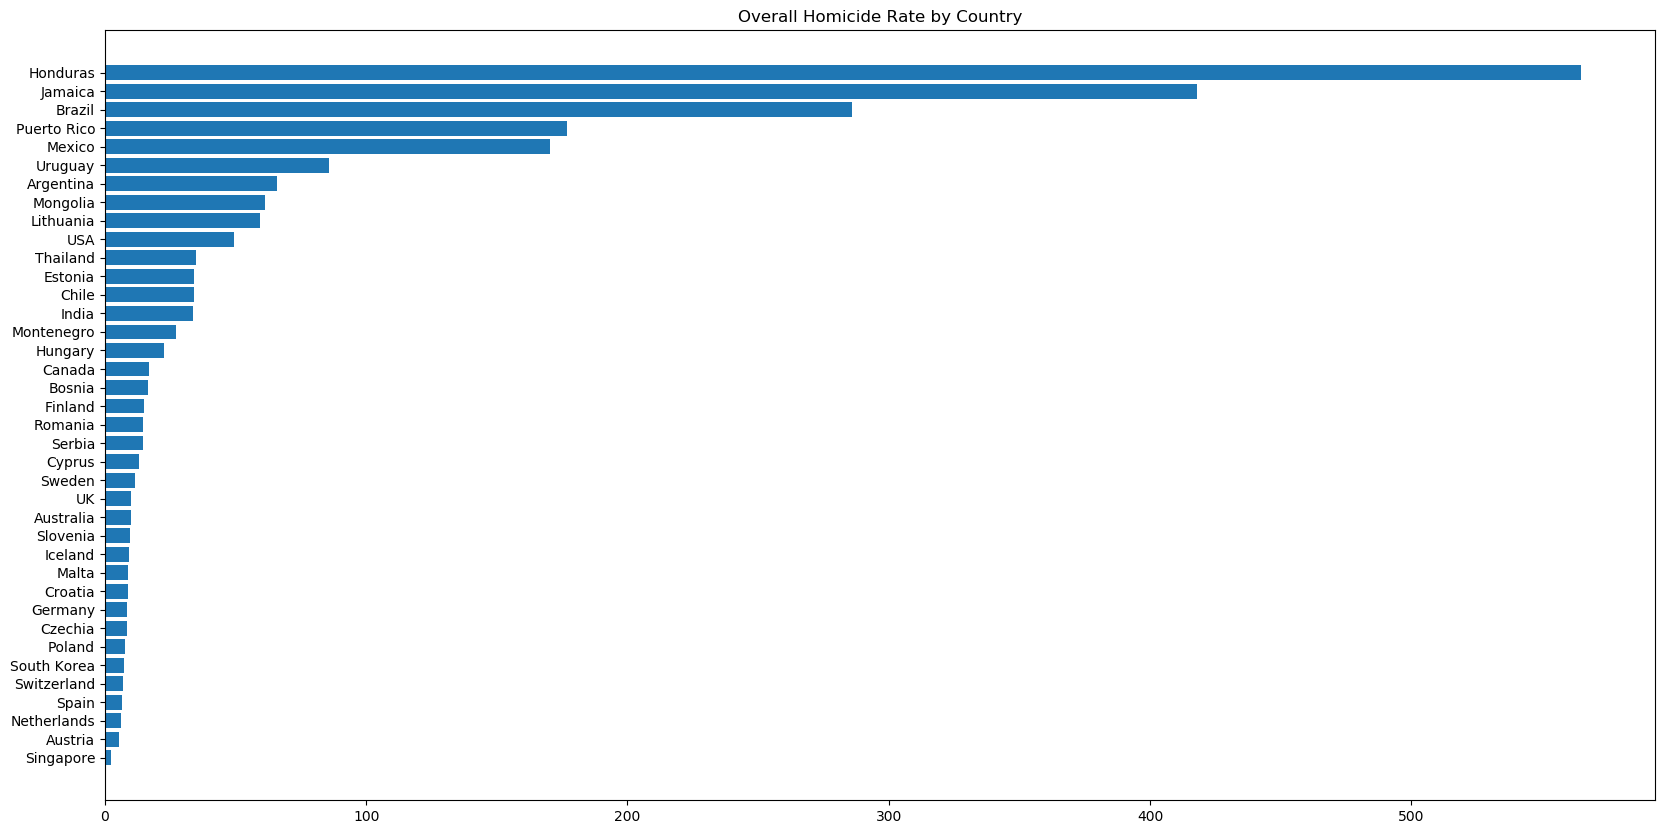

In [72]:
clean_df = clean_df.rename(index={'United Kingdom of Great Britain and Northern Ireland': 'UK', 
                                  'United States of America': 'USA', 
                                  'Bosnia and Herzegovina': 'Bosnia', 
                                  'Republic of Korea': 'South Korea'})

plt.figure(figsize=(20, 10))
plt.barh(clean_df.sort_values('Homicide_Rate').index, clean_df.sort_values('Homicide_Rate')['Homicide_Rate'])
plt.title('Overall Homicide Rate by Country')
plt.show()

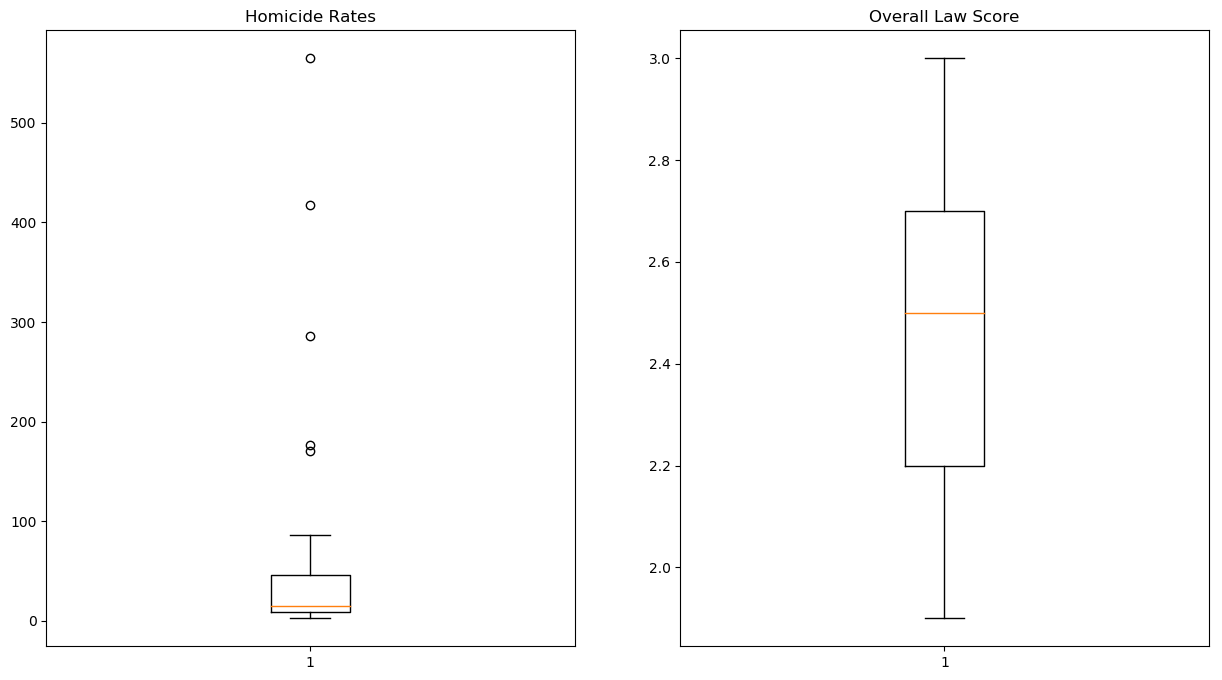

In [73]:
plt.figure(figsize=(15, 8))

plt.subplot(121)
plt.boxplot(clean_df['Homicide_Rate'])
plt.title('Homicide Rates')

plt.subplot(122)
plt.boxplot(clean_df['Overall_Law_Score'])
plt.title('Overall Law Score')
plt.show()

### Extremely Violent Countries
The homicide rates for Mexico, Puerto Rico, Brazil, Jamaica, and Honduras are so extreme that keeping them in the analysis will skew the results. With such levels of violence, it is likely other factors, such as government corruption, civil unrest, etc., will overshadow any effects from gun laws. Therefore, they will be dropped from the dataset.

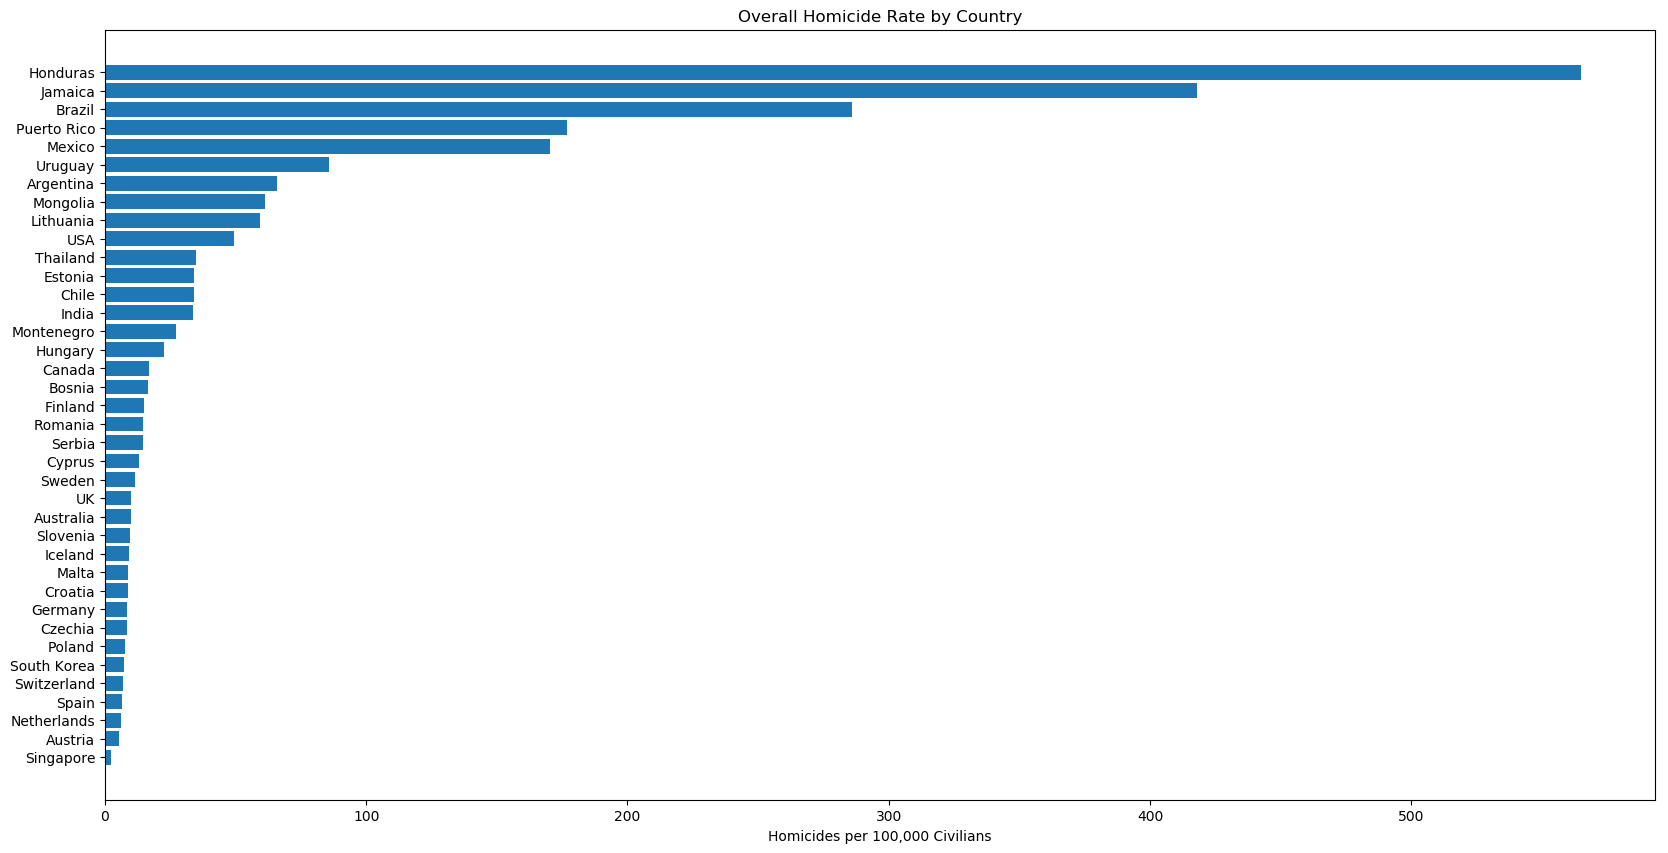

In [74]:
# to_drop = ['Brazil', 'Honduras', 'Jamaica', 'Mexico', 'Puerto Rico']
# clean_df = clean_df.drop(to_drop)

plt.figure(figsize=(20, 10))
plt.barh(clean_df.sort_values('Homicide_Rate').index, clean_df.sort_values('Homicide_Rate')['Homicide_Rate'])
plt.title('Overall Homicide Rate by Country')
plt.xlabel('Homicides per 100,000 Civilians')
plt.show()

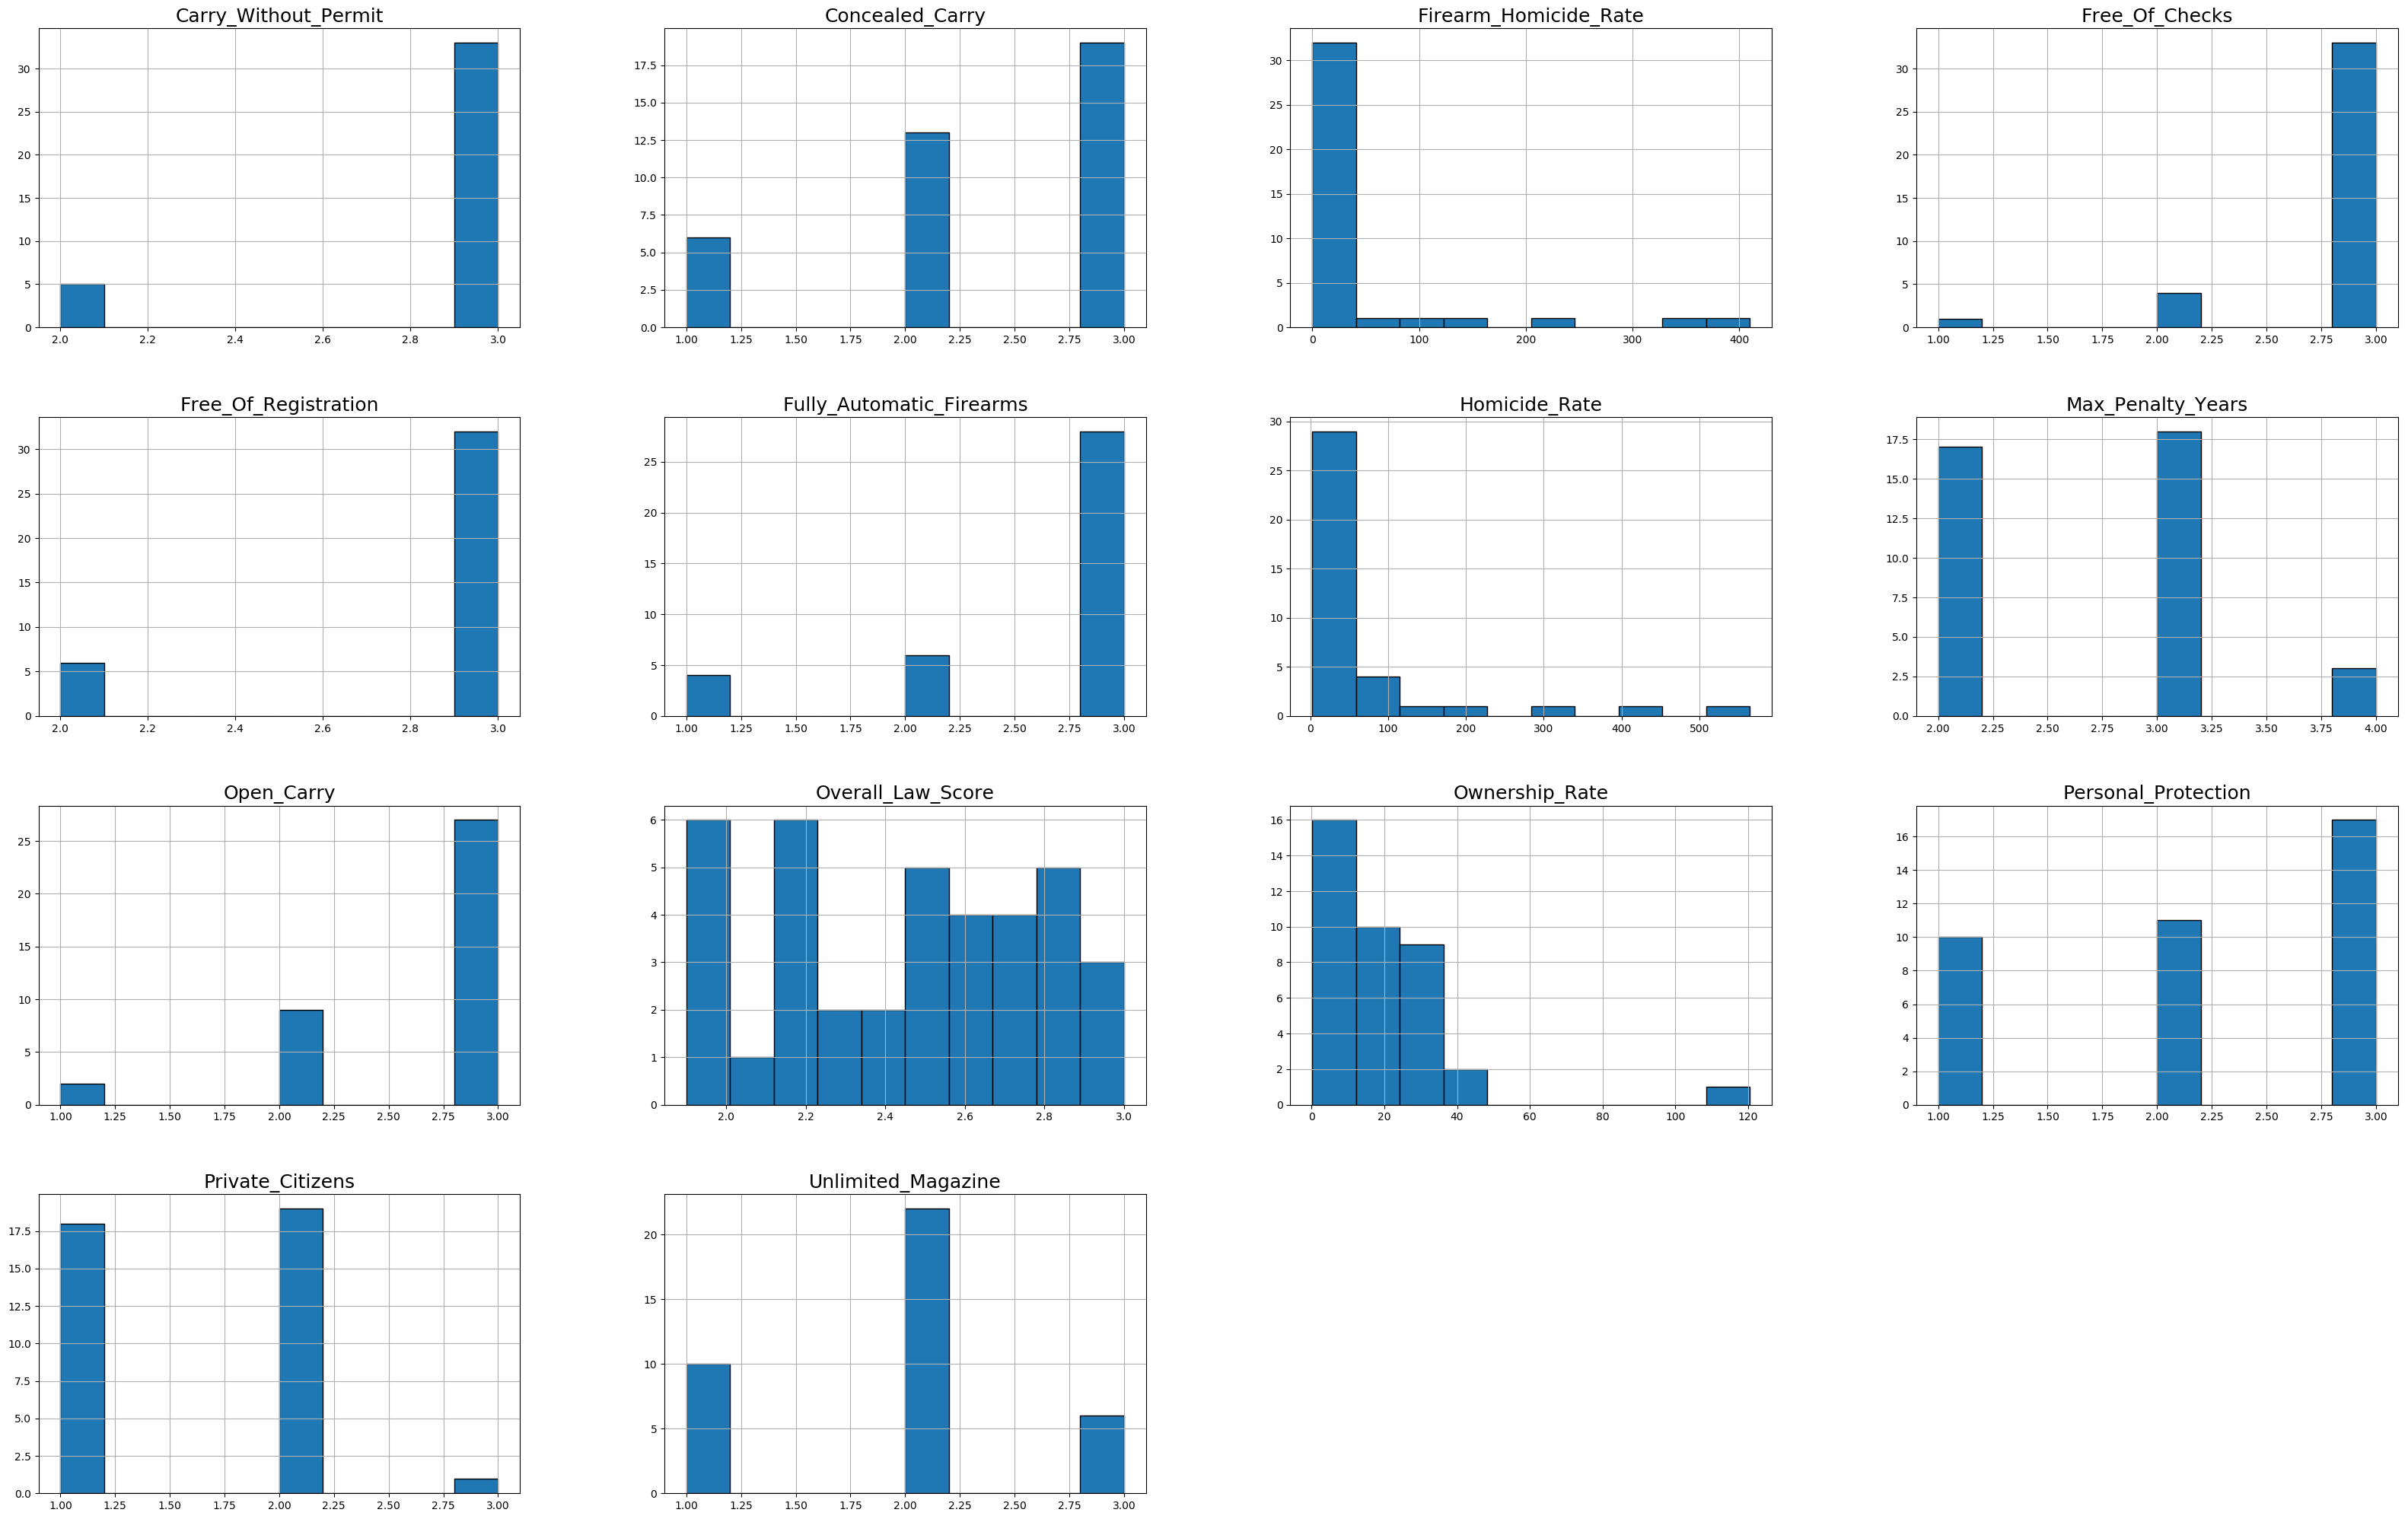

In [75]:
# View feature distributions
fig = clean_df.hist(figsize = (40, 25), ec='k')
[x.title.set_size(18) for x in fig.ravel()]
plt.show()

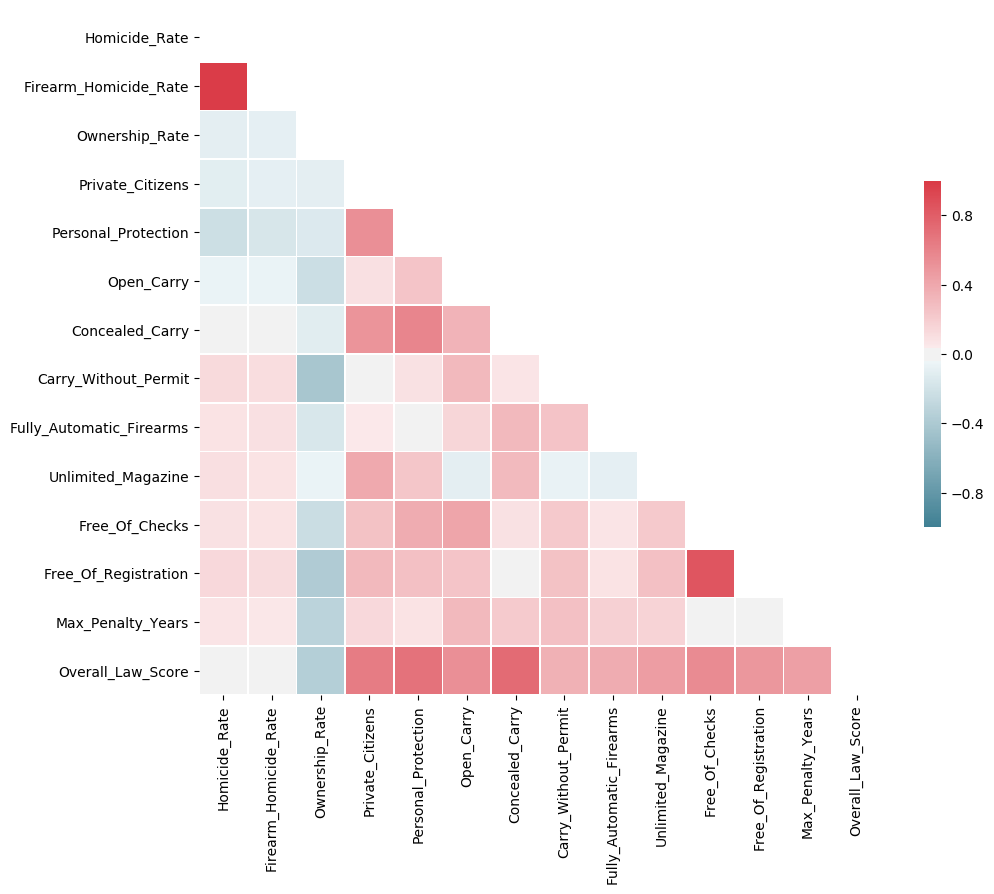

In [76]:
import seaborn as sns
import matplotlib as mpl

def coll_check(data, size=(11,9)):
    
    mpl.rcParams.update(mpl.rcParamsDefault)
    # Create a covariance matrix
    corr = data.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize = size)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
coll_check(clean_df)

### Initial Observations
No clear signs of normality in the data, but only data for 33 countries to work with. This probably won't be a big deal because independent variables will be measured individually against the target, and not in a multi-linear regression for the time being. 

Overall strictness of laws does seem to have a stronger, negative correlation when comparing nations than it does at the state level, but it remains to be seen whether the strength of this correlation is statistically significant.

### Regression Analysis
Before conducting an investigation using multi-linear regression, each predictor will be individually reviewed to get a sense of significance with each target variable. Though a p-value of 5% would normally be the threshold, we will also examine results at the 10% threshold to get a broader picture of the results.

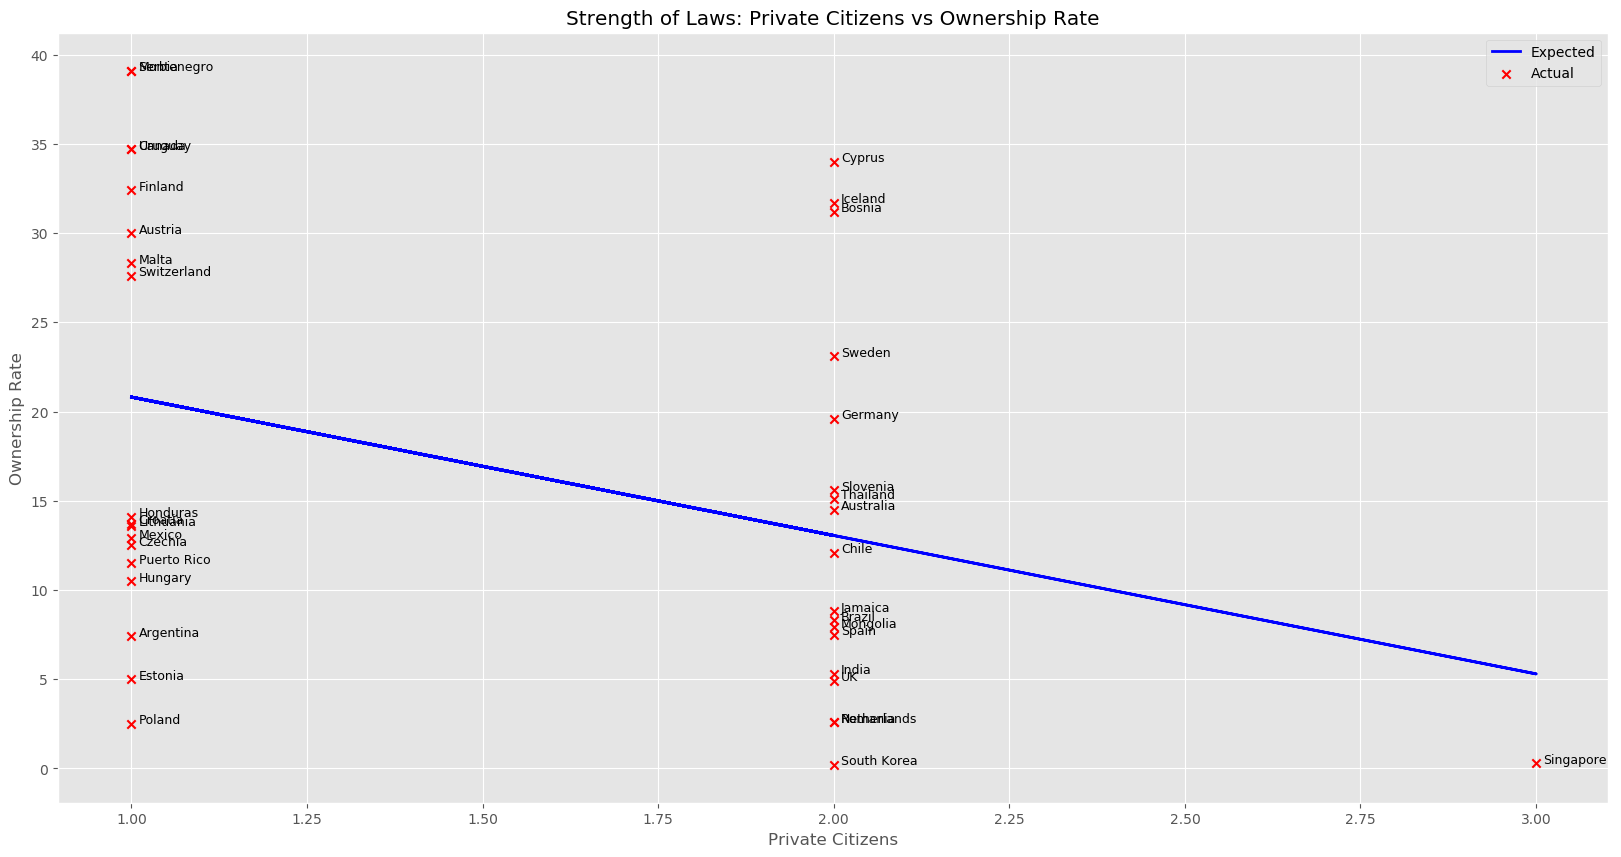

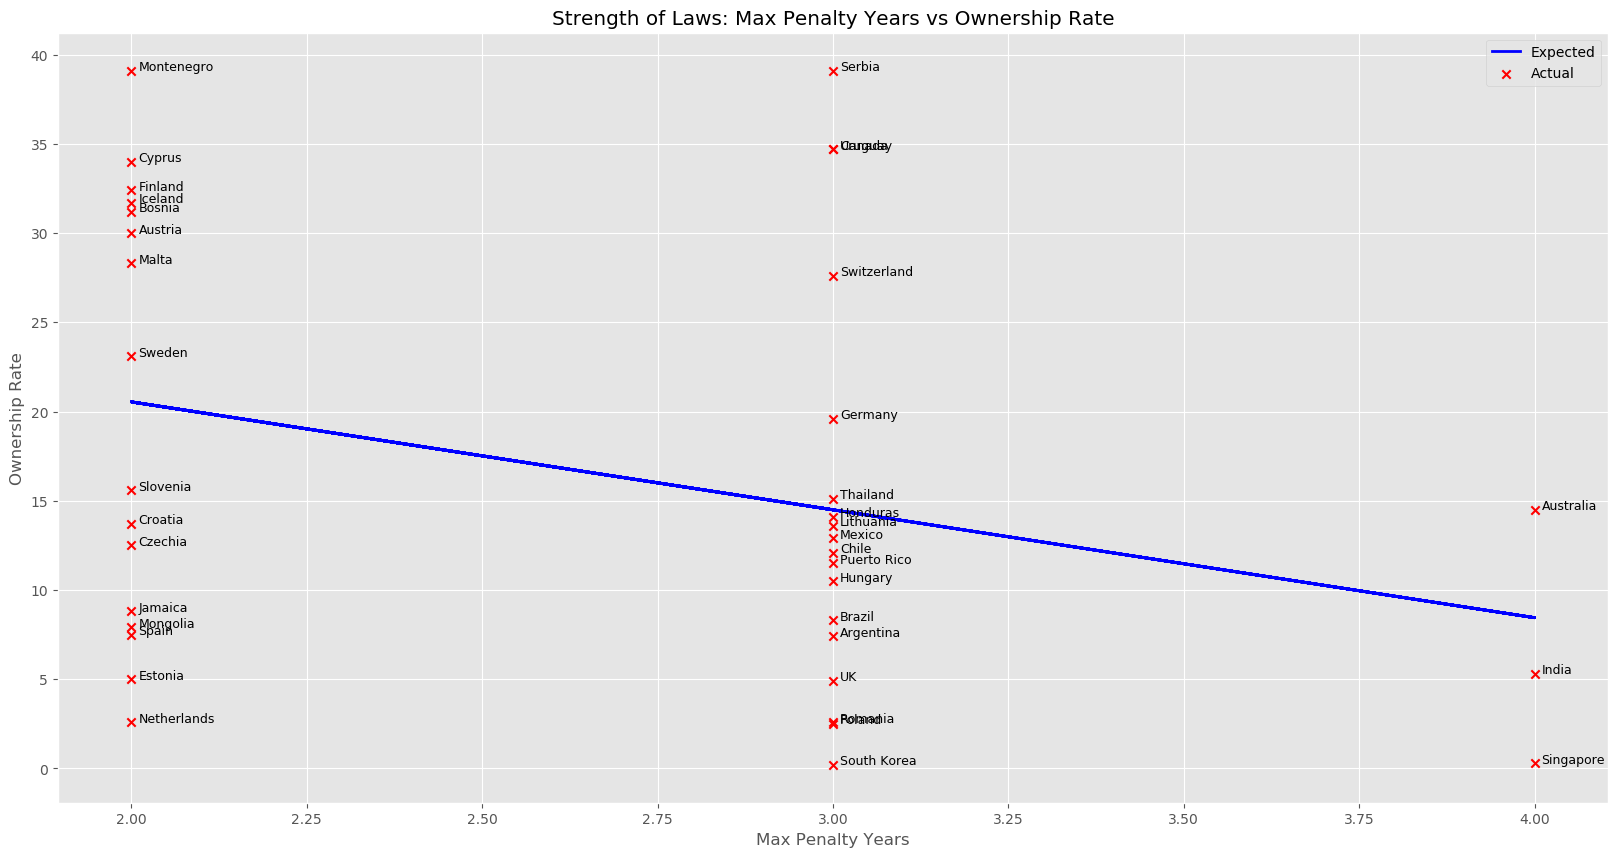

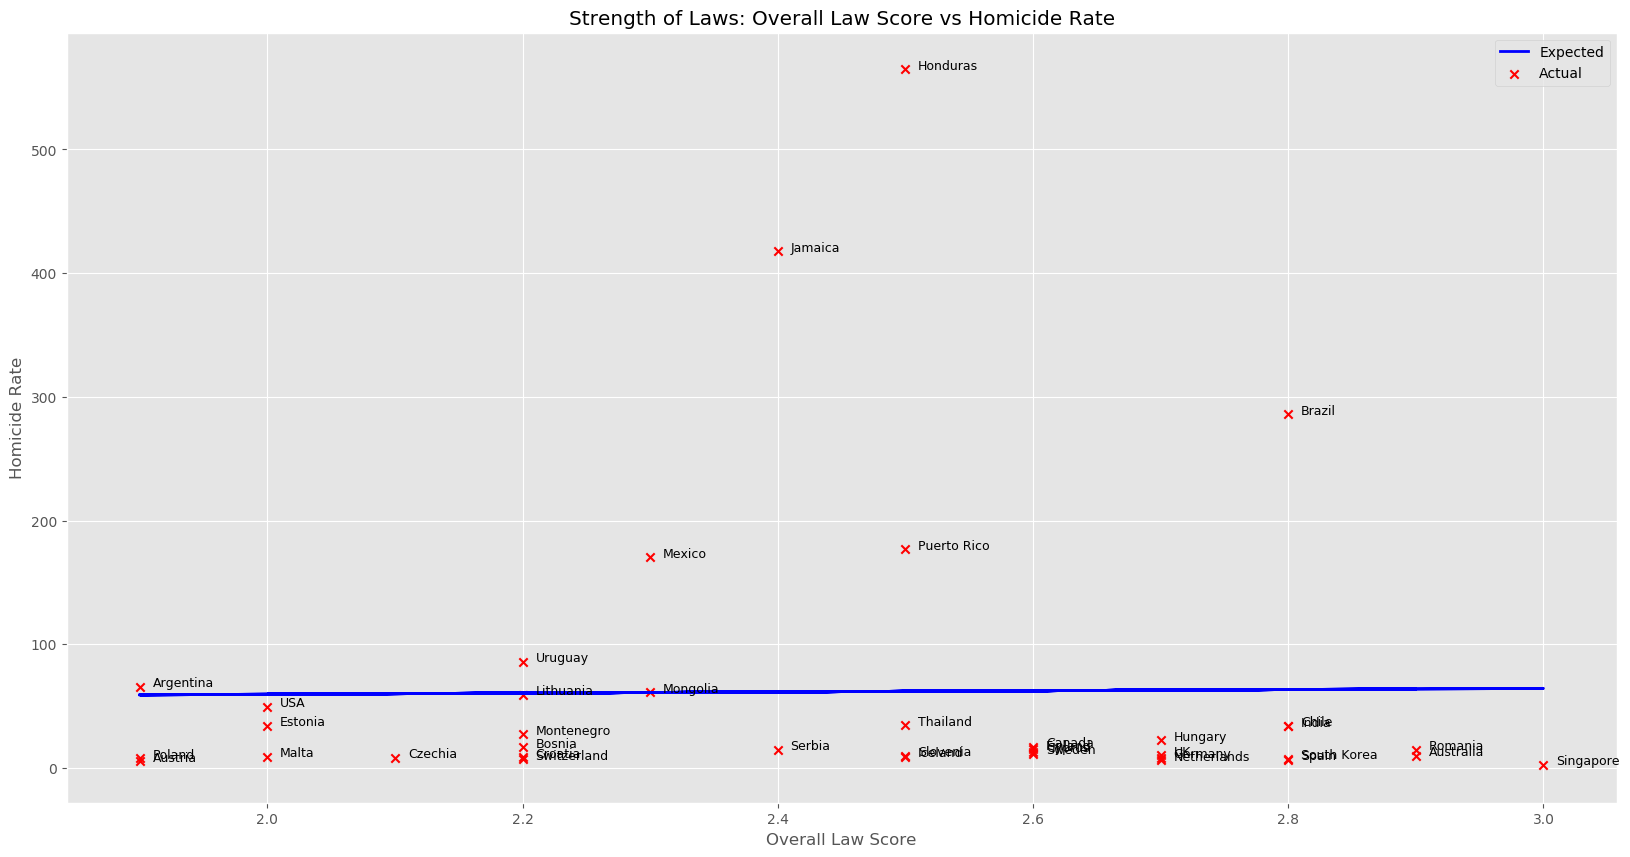

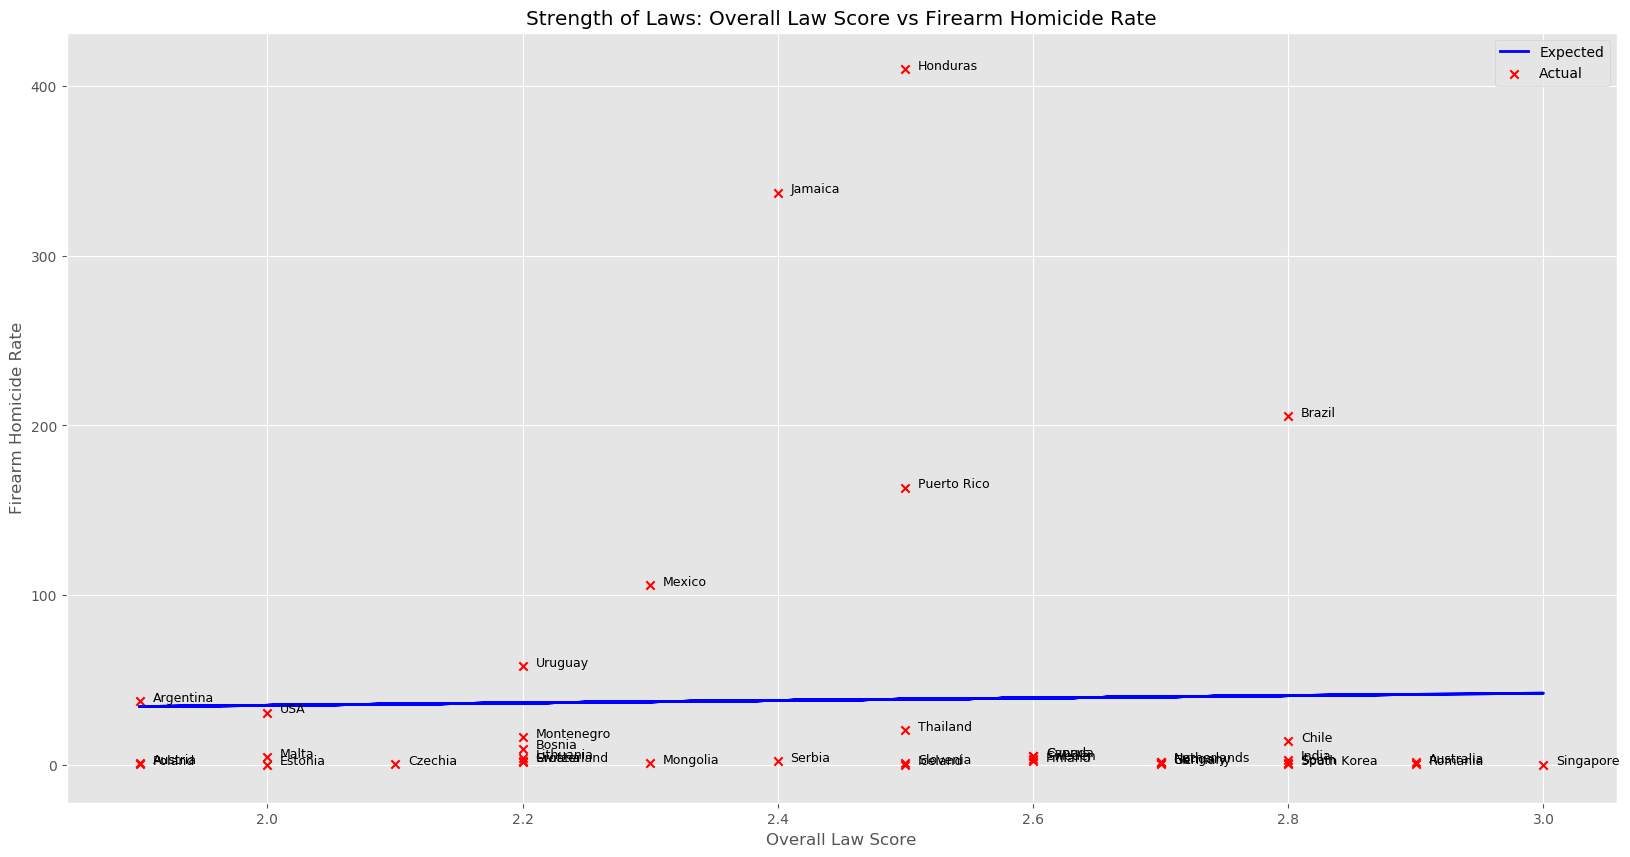

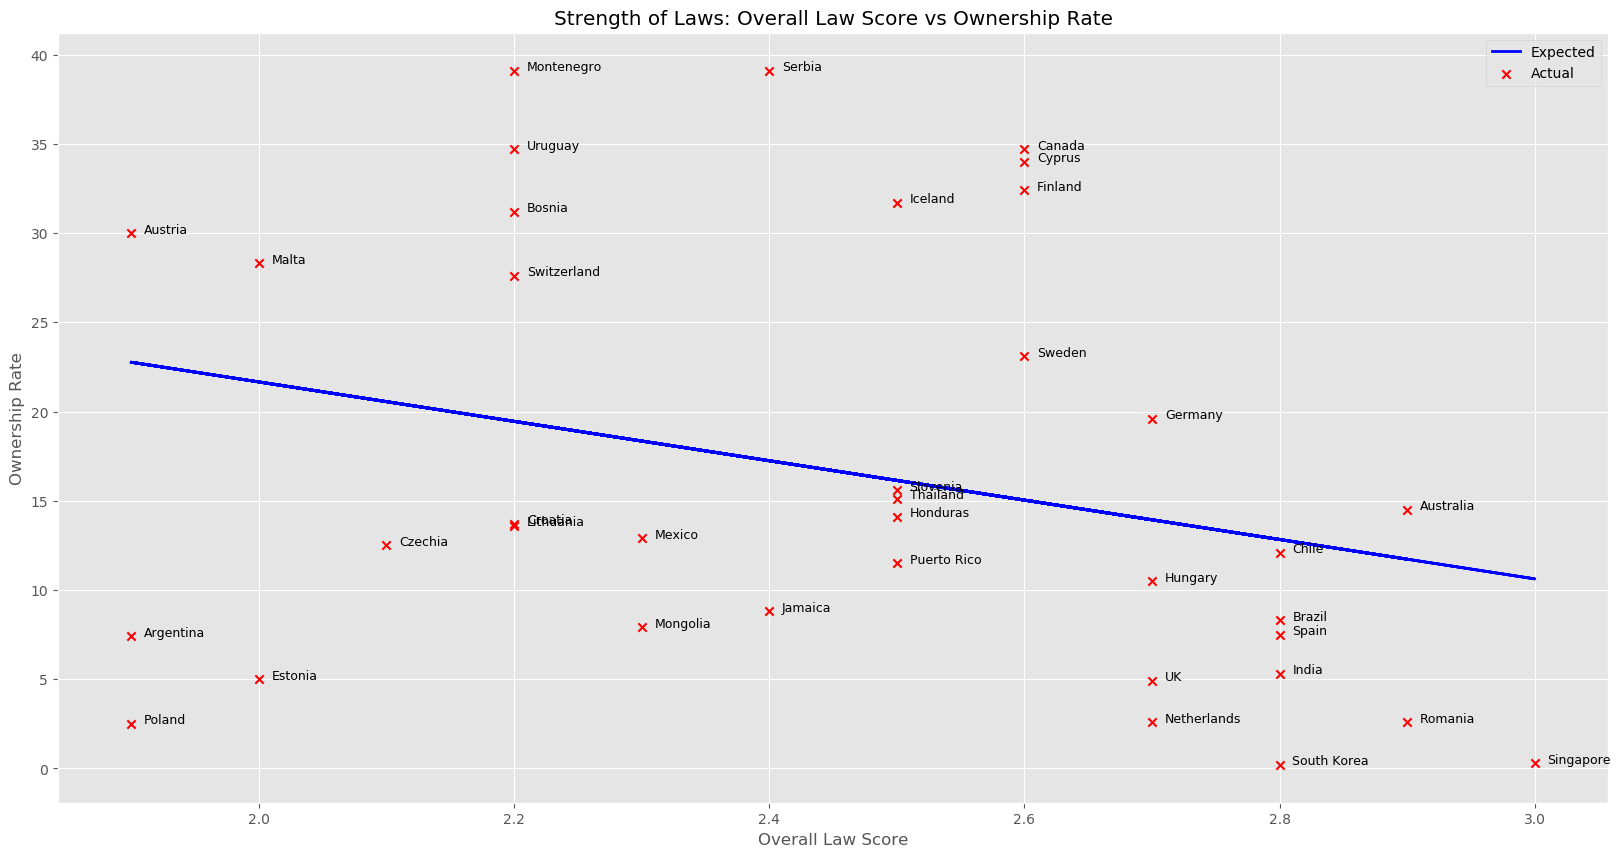

,Target,Predictor,R Squared,Intercept,Slope,P Value
0,Ownership Rate,Private Citizens,0.129607,28.566667,-7.755556,0.028621
1,Ownership Rate,Max Penalty Years,0.101586,32.631835,-6.045693,0.054521
2,Homicide Rate,Overall Law Score,0.000162,50.004060,4.758343,0.939506
3,Firearm Homicide Rate,Overall Law Score,0.000614,20.642870,7.176391,0.882624
4,Ownership Rate,Overall Law Score,0.082829,43.734262,-11.037048,0.084114


In [77]:
import statsmodels.formula.api as smf

def run_regressions(data):
    plt.style.use('ggplot')

    targets = data.columns[:3]
    predictors = data.columns[3:]

    results = [['Target', 'Predictor', 'R Squared', 'Intercept', 'Slope', 'P Value']]

    for predictor in predictors:
        Predictor = predictor.replace("_", " ")
        
        for target in targets:
            Target = target.replace("_", " ")
                        
            if (target == 'Ownership_Rate') or (predictor == 'Ownership_Rate'):
                df = data.drop('USA')
            else:
                df = data
            
            labels = list(df.index)
                
            if predictor != target:
                f = f'{target}~{predictor}'
                model = smf.ols(formula=f, data=df).fit()
                
                if (model.pvalues[1] <= .1) or (predictor == 'Overall_Law_Score'):
                    results.append([Target, Predictor, model.rsquared, model.params[0], model.params[1], model.pvalues[1]])
                    y_pred = model.predict()
                    plt.figure(figsize=(20, 10))
                    plt.title(f'Strength of Laws: {Predictor} vs {Target}')
                    plt.xlabel(Predictor)
                    plt.ylabel(Target)
                    
                    for i,country in enumerate(labels):
                        try:
                            x = list(df[predictor])[i]
                            y = list(df[target])[i]
                            plt.scatter(x, y, marker='x', color='red', label='Actual' if i ==0 else None)
                            plt.text(x+0.01, y+.01, country, fontsize=9)
                        except:
                            pass
        #                 plt.scatter(clean_df[predictor], clean_df[target], marker='.', label='Actual')
                    plt.plot(df[predictor], y_pred, color='b', lw=2, label='Expected')
                    plt.legend()
                    plt.show()

        result_df = pd.DataFrame(results[1:],columns=results[0])

    return result_df, predictors, targets

clean_results, clean_predictors, clean_targets = run_regressions(clean_df)
clean_results

There are two legal features which appear to have a very statistically significant impact on overall homicide rates: personal protection and concealed carry.

- **Personal Protection:** Countries that give less consideration to personal protection as a valid reason to purchase a gun have significantly fewer homicides. 
- **Concealed Carry:** Countries that have more restrictions on concealed carry also have significantly fewer homicides.

The overall law score falls just shy of the 95% confidence threshold, and inspection of the graph reveals a substantial amount of heteroskedasticity, though not in the direction traditionally exhibited. Rather than variance increasing as law strength increases, variance decreases. A log transformation will be attempted, but the results seem to suggest that while strong gun laws can generally be equated with lower homicide rates, weak gun laws can go either direction. 

Another item worth noting is that, even though a number of items do appear to have a significant, or near-significant impact on firearm homicide rates, they don't all translate to reduction homicide rates. Most specifically, while background checks do have a statistically impact on firearm homicide rates, it does not translate to reductions in total homicides.

Strong restrictions on private citizen gun ownership does have a strong correlation with the ownership rate, but it does not appear to translate into reductions in homicide rates of any kind.

## Log Transformation
To be performed on continuous variables only: target variables and overall strength of laws. Because all predictors are in the same units, there is no need to perform any standardization.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


<function matplotlib.pyplot.show(*args, **kw)>

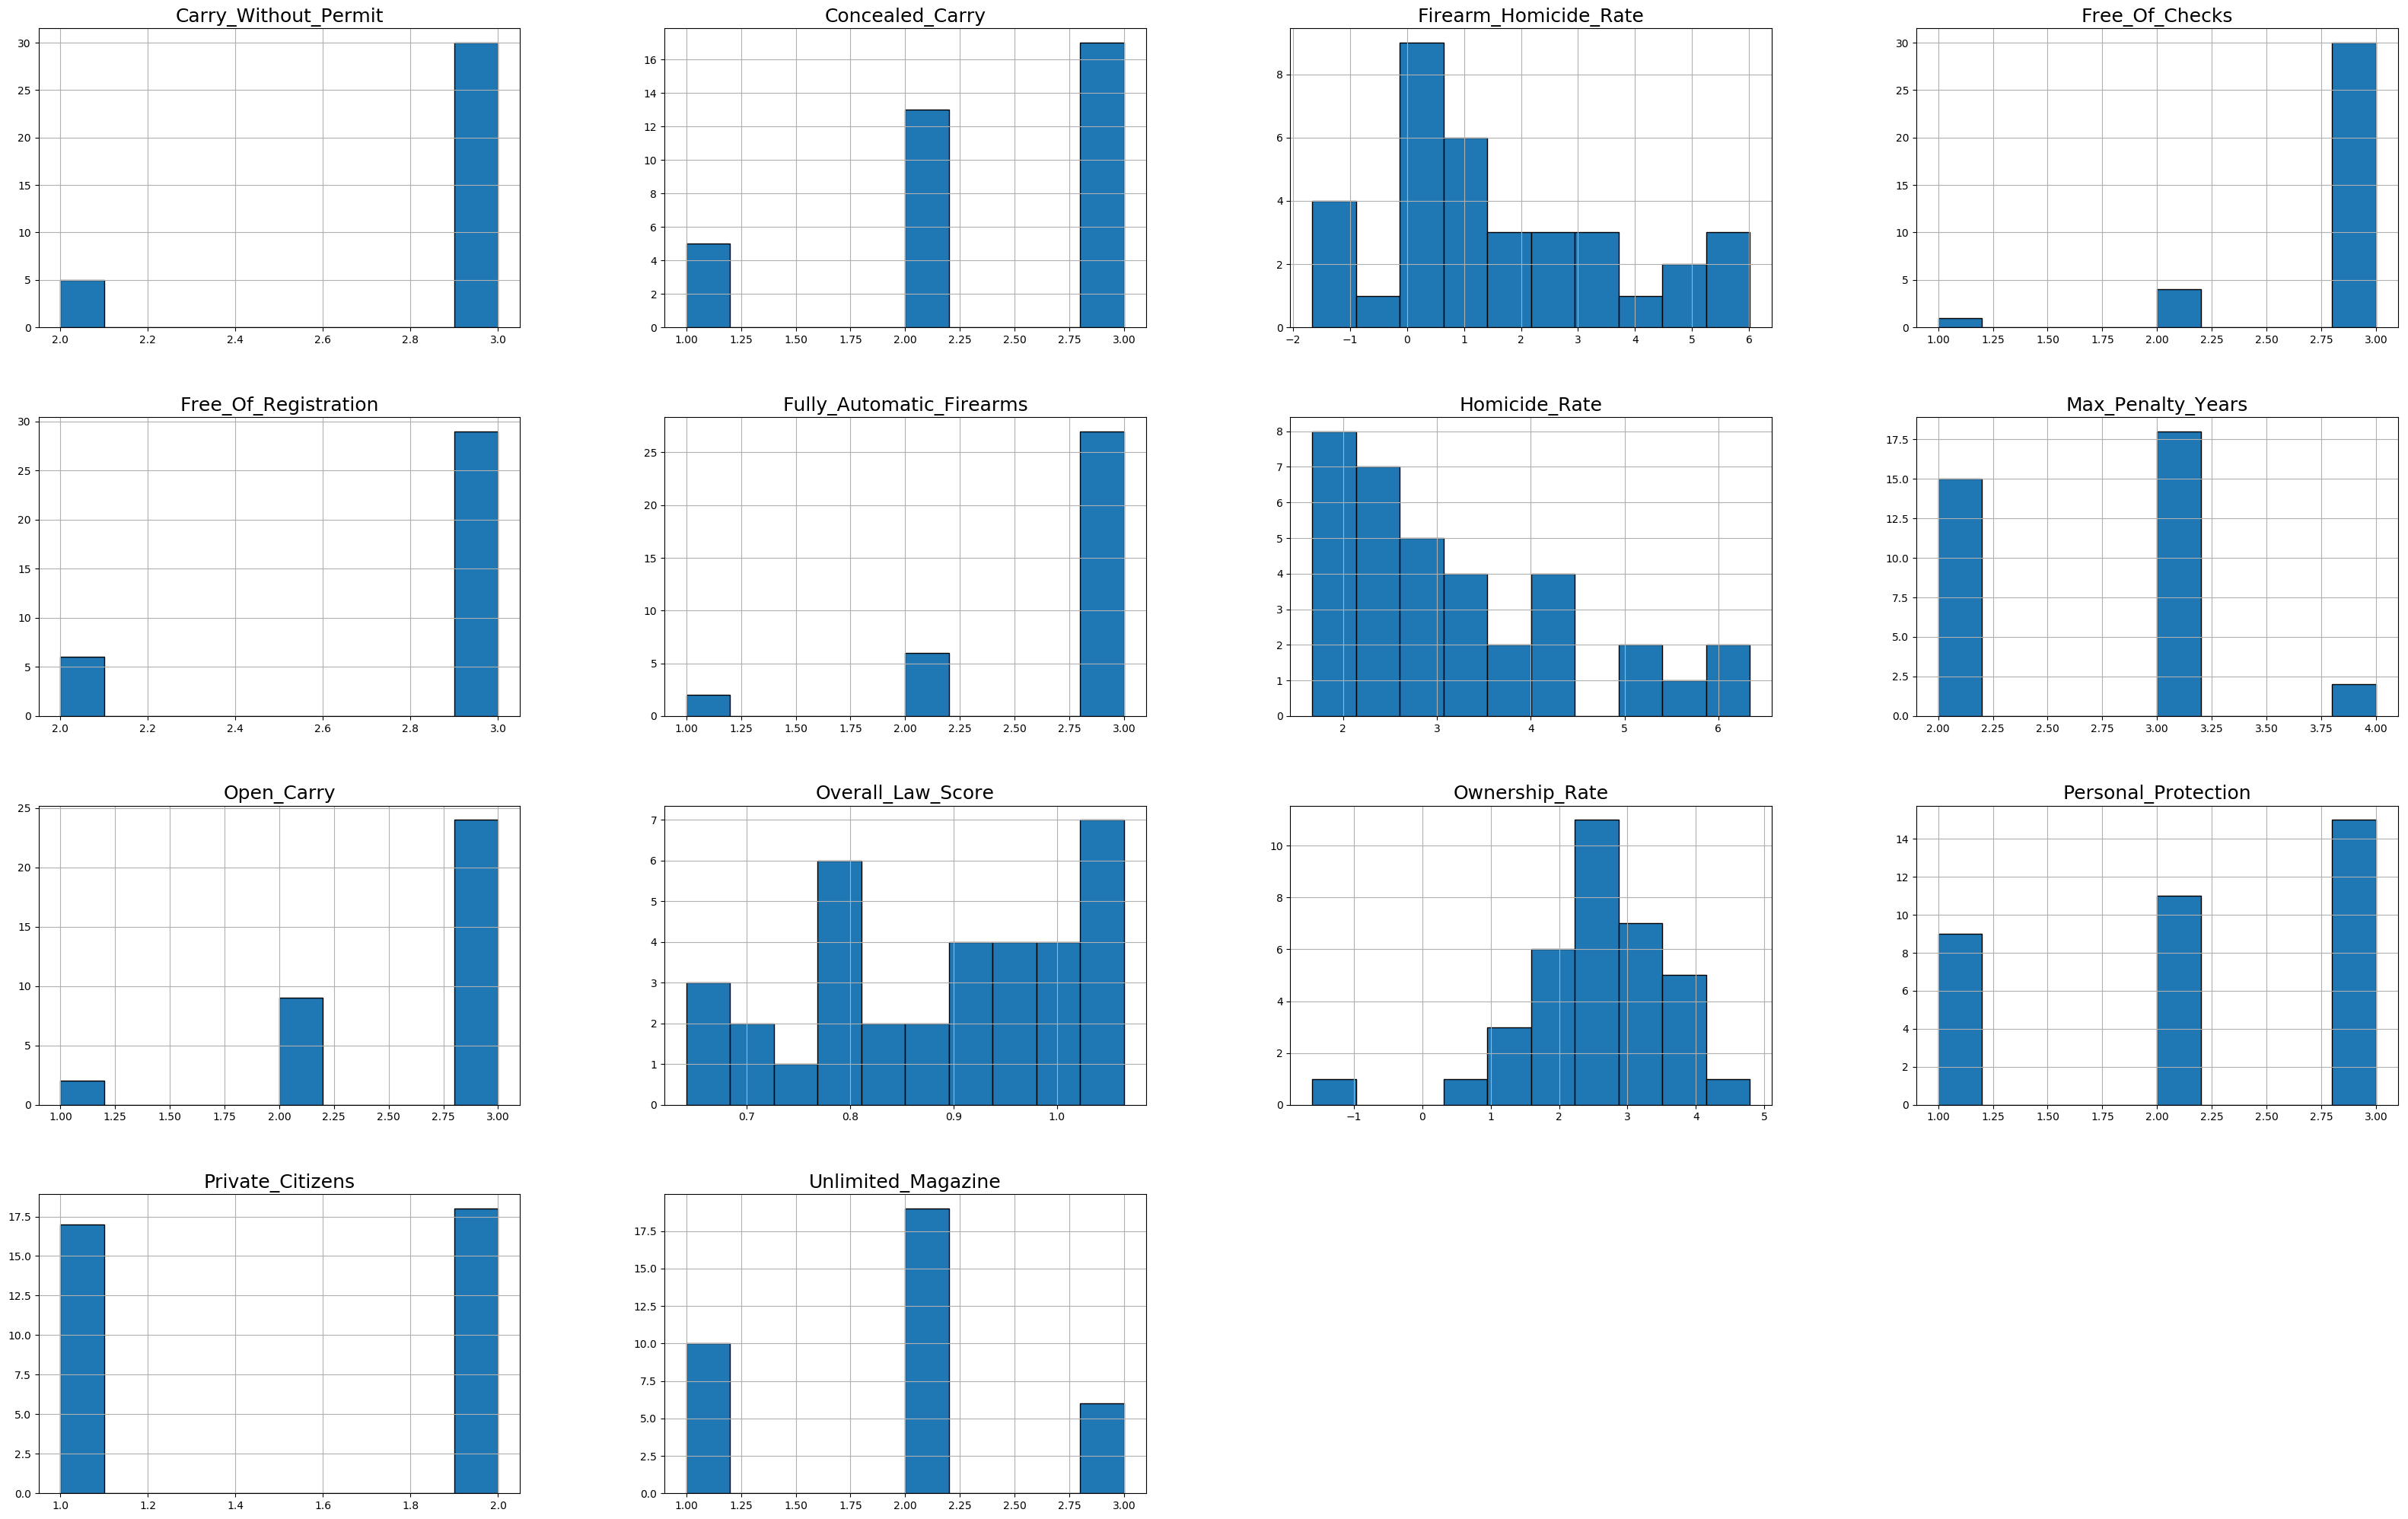

In [29]:
from sklearn import preprocessing

log_df = pd.DataFrame()

cols = list(clean_df.columns[:3]) + [clean_df.columns[-1]]

for col in cols:
    log_df[col] = np.log(clean_df[col])

for col in clean_df.columns[3:-1]:
    log_df[col] = clean_df[col]
    
log_df = log_df.replace([np.inf, -np.inf], np.nan).dropna()
# transformed_df = pd.DataFrame(preprocessing.scale(log_df), columns = log_df.columns).set_index(log_df.index)
    
transformed_df = log_df

mpl.rcParams.update(mpl.rcParamsDefault)
fig = transformed_df.hist(figsize=(40, 25), ec='k')
[x.title.set_size(18) for x in fig.ravel()]
plt.show

It appears that transformations resulted in infinite values for certain countries, which were dropped as a result. The three countries in question are Estonia, Iceland, and Singapore. 

In [30]:
for country in clean_df.index:
    if country not in transformed_df.index:
        print(country)

Estonia
Iceland
Singapore


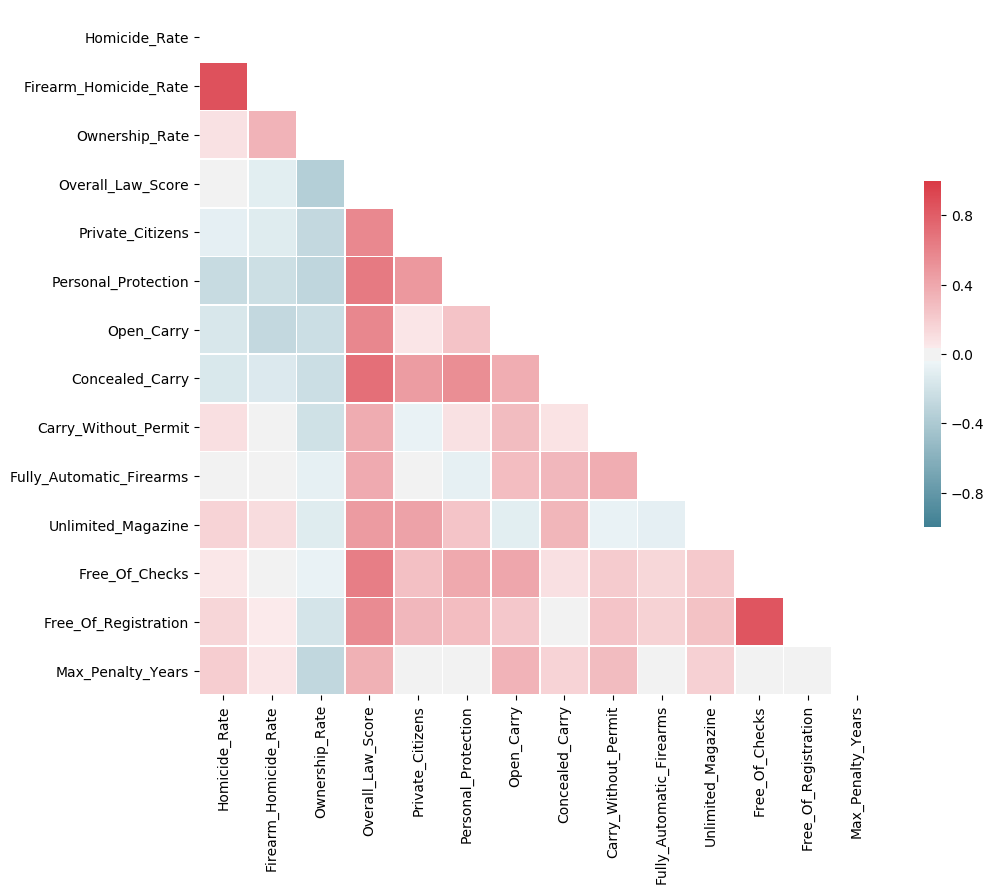

In [31]:
coll_check(transformed_df)

#### Observations
First impressions suggest that a log transformation did not result in any significant improvements with regard to normality, nor has it improved correlation measures. Will be investigated further, nonetheless.

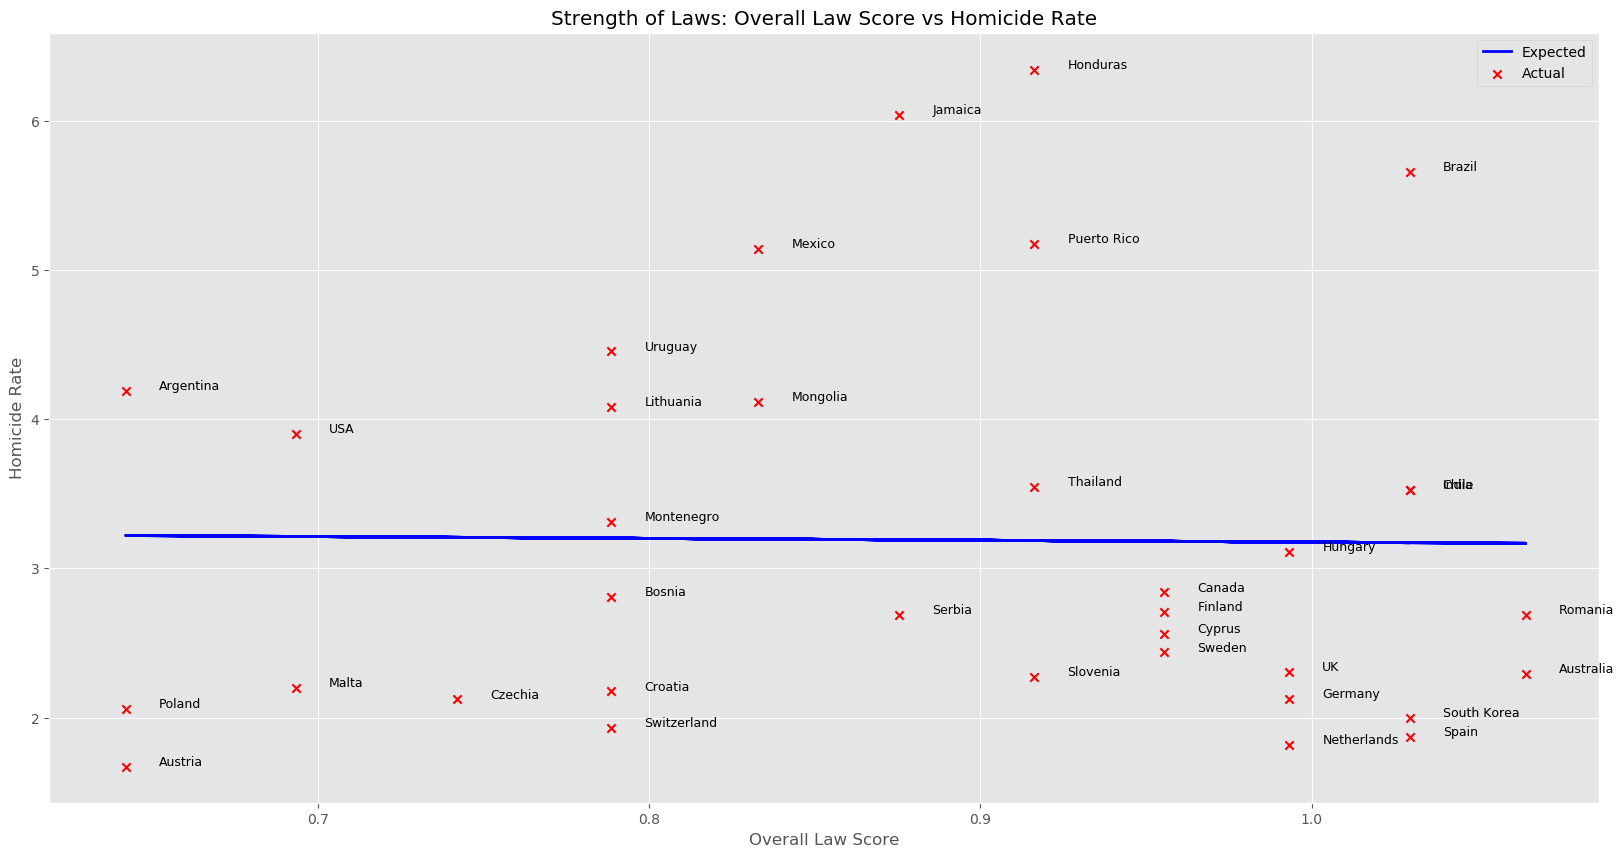

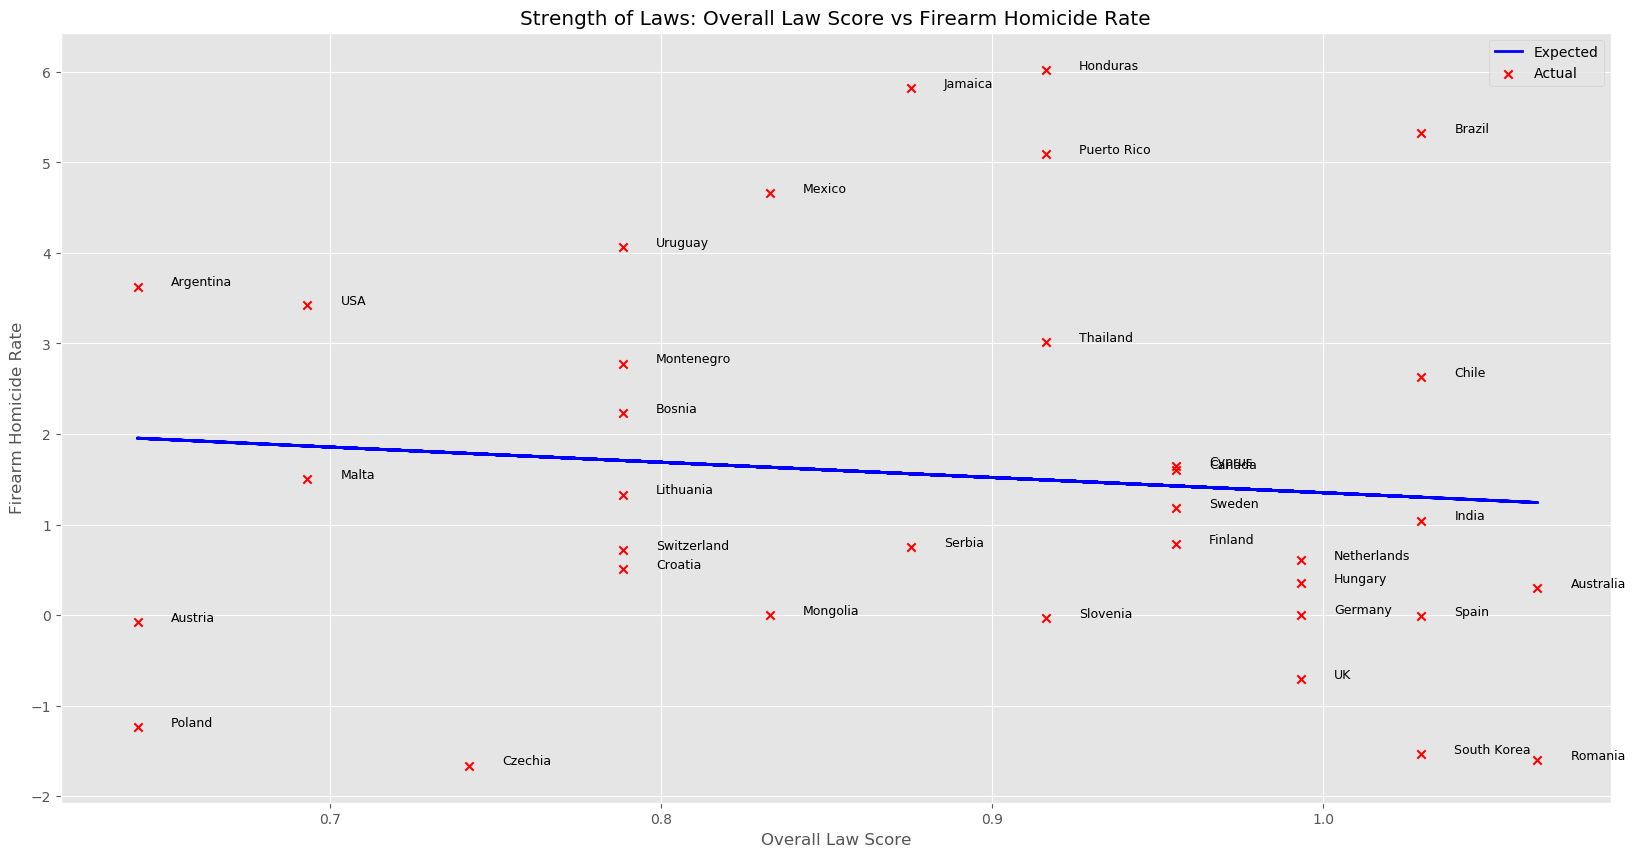

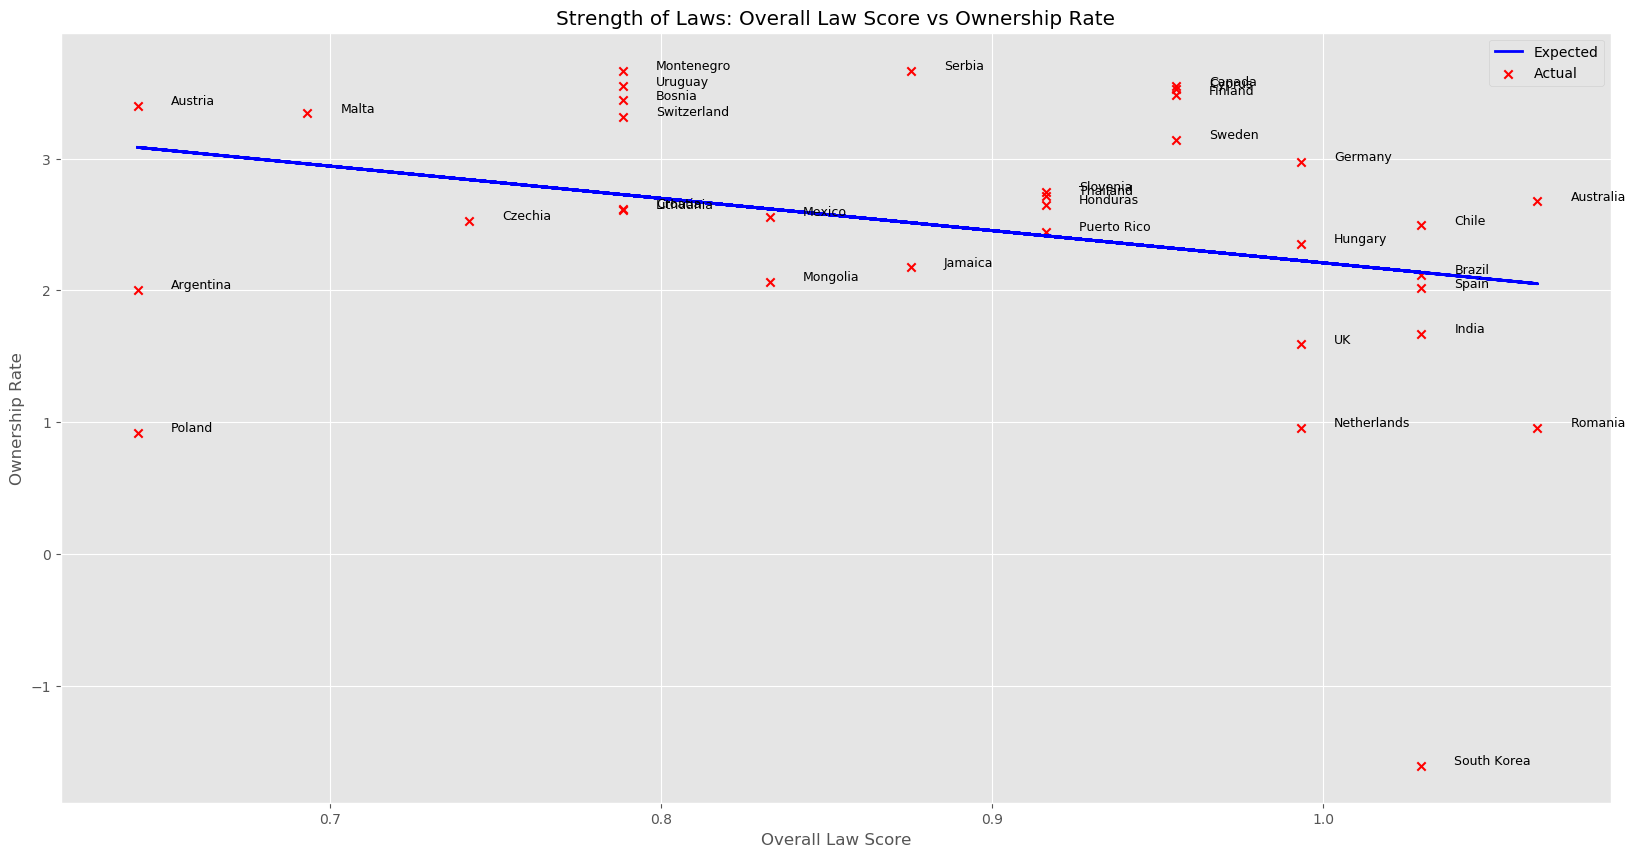

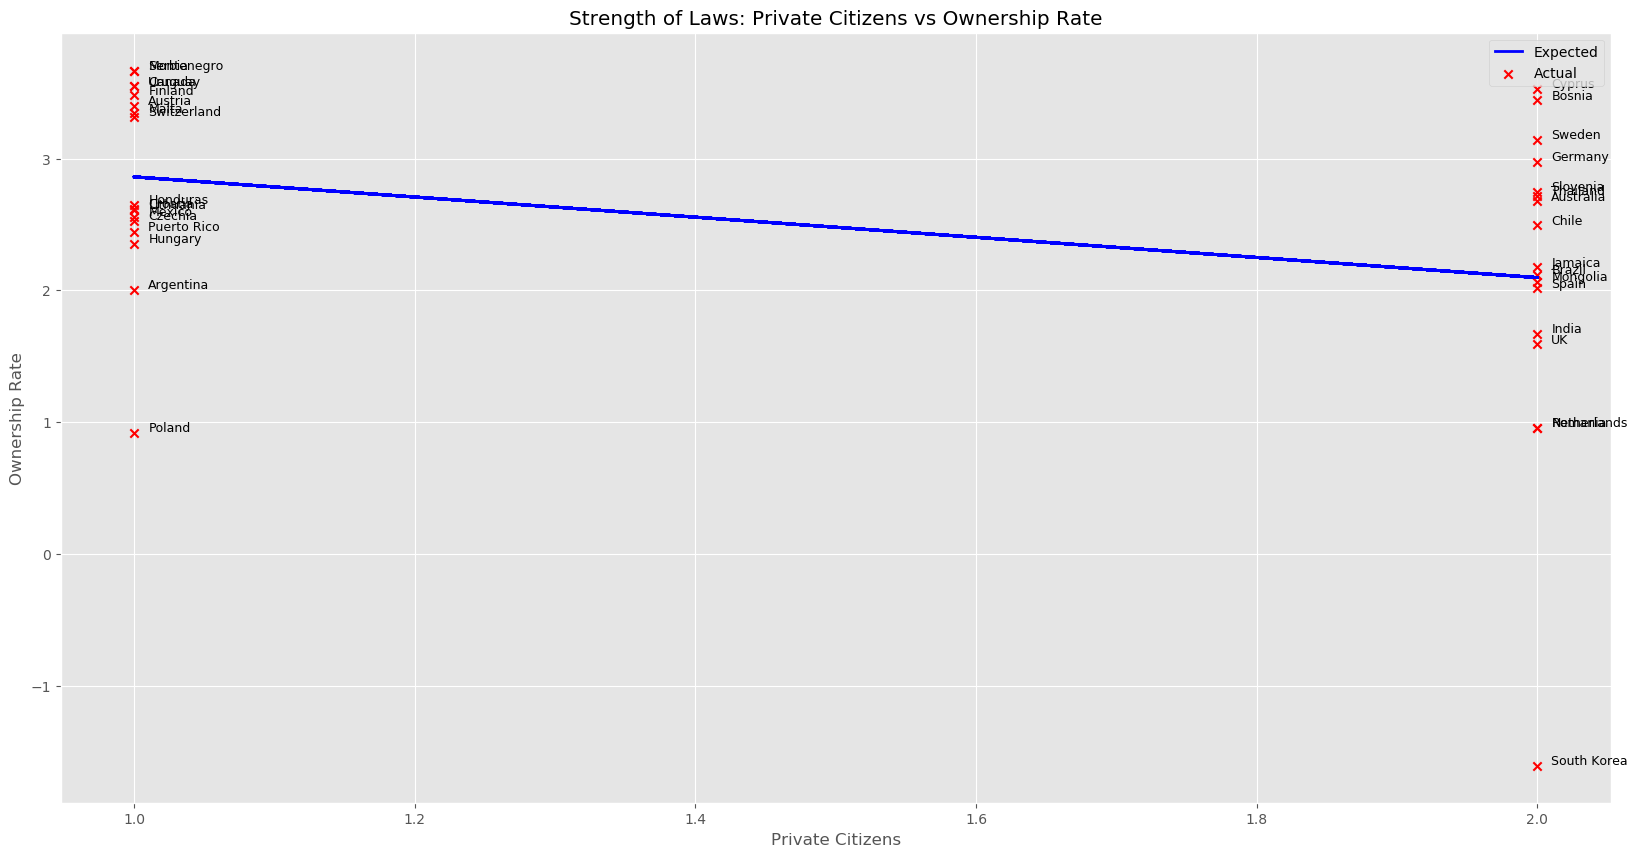

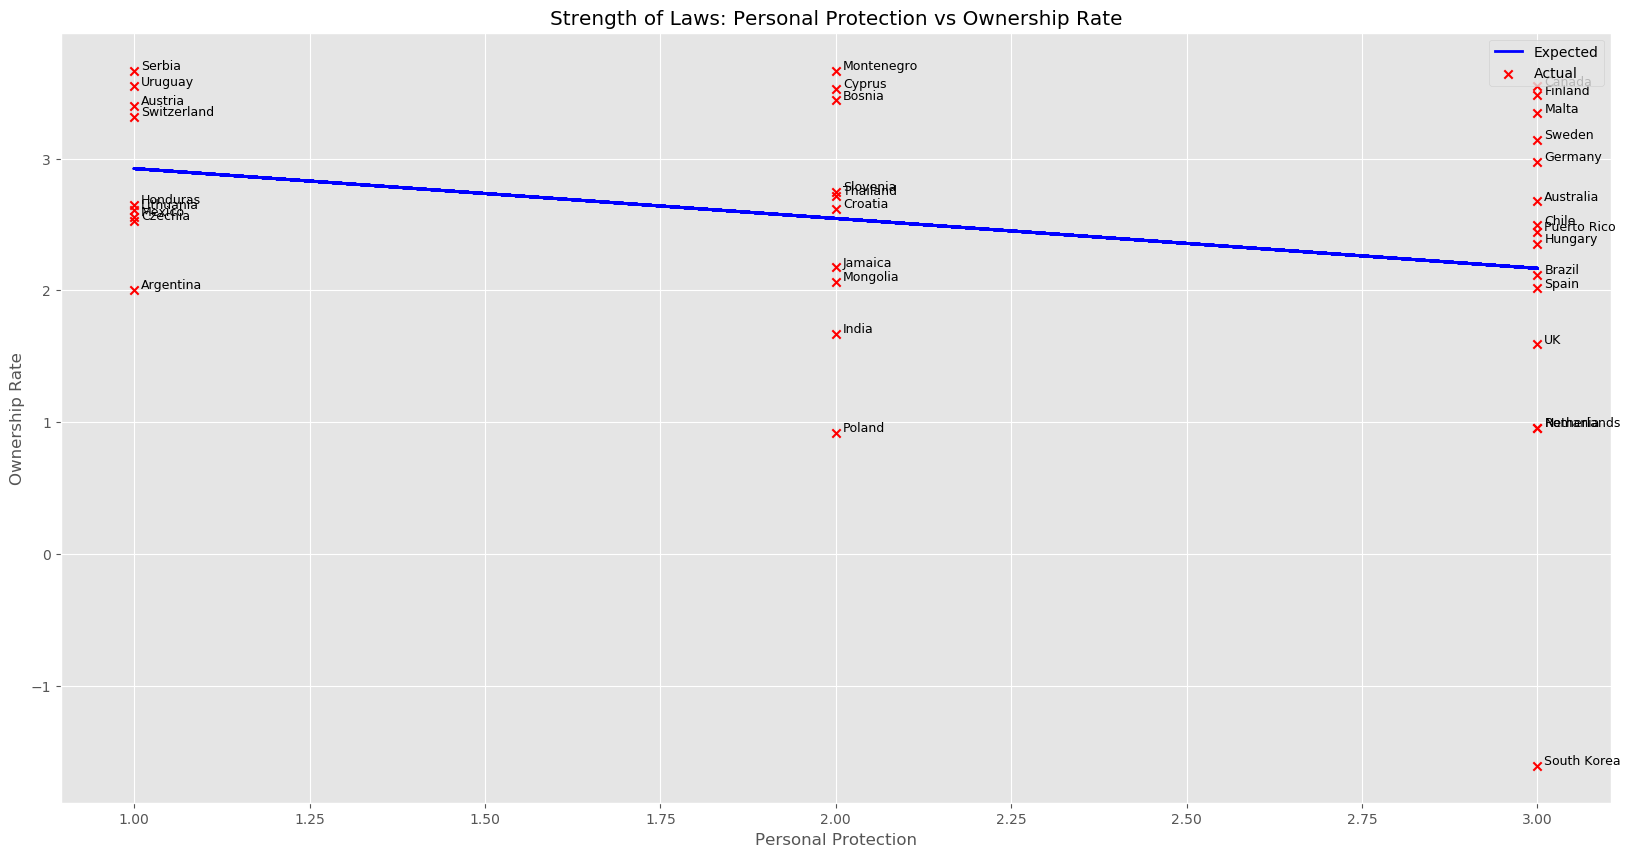

,Target,Predictor,R Squared,Intercept,Slope,P Value
0,Homicide Rate,Overall Law Score,0.000157,3.299082,-0.123694,0.943073
1,Firearm Homicide Rate,Overall Law Score,0.010340,3.032525,-1.680654,0.561068
2,Ownership Rate,Overall Law Score,0.085507,4.654358,-2.445675,0.093310
3,Ownership Rate,Private Citizens,0.132563,3.624996,-0.764182,0.034272
4,Ownership Rate,Personal Protection,0.087681,3.302090,-0.378303,0.089057


In [32]:
transformed_results, transformed_predictors, transformed_targets = run_regressions(transformed_df)
transformed_results

It is not surprising that log transformations did not help much: all target variables were in units per capita anyway, and log transformations would have also made the results significantly more difficult to interpret. We will stick with data in its original form when performing multi-linear regression analysis.

### Multiple Linear Regression
It is not expected, but worth checking to see if a particular set of gun law features can significantly reduce homicide rates. Here, we will look at all possible combinations of independent variables to find the best performing combination (those that result in the lowest Root Mean Squared Error) with respect to each target variable. The target and predictors are redefined here for the reader's convenience.

In [33]:
list(clean_targets)

['Homicide_Rate', 'Firearm_Homicide_Rate', 'Ownership_Rate']

In [34]:
clean_predictors = list(clean_predictors) + ['Ownership_Rate']
clean_predictors

['Private_Citizens',
 'Personal_Protection',
 'Open_Carry',
 'Concealed_Carry',
 'Carry_Without_Permit',
 'Fully_Automatic_Firearms',
 'Unlimited_Magazine',
 'Free_Of_Checks',
 'Free_Of_Registration',
 'Max_Penalty_Years',
 'Overall_Law_Score',
 'Ownership_Rate']

In [35]:
# Create combinations of predictor variables for regression analysis
from itertools import combinations as comb

combs = []
for i in range(1, len(clean_predictors)+1):
    combs+=list(comb(clean_predictors, i))

len(combs)

4095

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import time

best_models = []

# Create loop to find best model for each target variable
for target in clean_targets[:2]:
    
    print(f'\nTarget: {target.replace("_", " ")}')
    X_train, X_test, y_train, y_test = train_test_split(clean_df[clean_predictors], 
                                                        clean_df[target],
                                                        test_size = .25, 
                                                        random_state = 123)
    
    # Create dictionary to track features of best performing model
    best_model = {'Target': None, 'Features': [], 'Train RMSE': 0, 'Test RMSE': 10000}
    i = 1
    t0 = time.time()
    t2 = time.time()
    for c in combs:

        linreg = LinearRegression()
        linreg.fit(X_train[list(c)], y_train)
        y_preds = linreg.predict(X_test[list(c)])
        y_train_preds = linreg.predict(X_train[list(c)])
        
        # Calculate root mean squared error and compare to best model so far
        rmse = np.sqrt(mean_squared_error(y_test, y_preds))
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_preds))
        if rmse < best_model['Test RMSE']:
            best_model['Features'] = list(c)
            best_model['Test RMSE'] = rmse
            best_model['Train RMSE'] = train_rmse
        
        # Track time and progress
        if i % np.round((len(combs) * .1), 0) == 0:
            t1 = time.time()
            print(f'{int(100 * i/len(combs))}% Complete')
            print(f'Total Time: {t1 - t0:.2f}s')
            print(f'Lap Time: {t1 - t2:.2f}s \n')
            t2 = time.time()

        i += 1
          
    print(f'{target.replace("_", " ")} 100% Complete\n')
    best_model['Target'] = target
    best_models.append(best_model)

# Return results
best_models


Target: Homicide Rate
10% Complete
Total Time: 1.16s
Lap Time: 1.16s 

20% Complete
Total Time: 2.29s
Lap Time: 1.13s 

30% Complete
Total Time: 3.50s
Lap Time: 1.21s 

40% Complete
Total Time: 4.71s
Lap Time: 1.20s 

50% Complete
Total Time: 5.93s
Lap Time: 1.23s 

60% Complete
Total Time: 7.15s
Lap Time: 1.22s 

70% Complete
Total Time: 8.38s
Lap Time: 1.22s 

80% Complete
Total Time: 9.56s
Lap Time: 1.18s 

90% Complete
Total Time: 10.71s
Lap Time: 1.16s 

Homicide Rate 100% Complete


Target: Firearm Homicide Rate
10% Complete
Total Time: 1.26s
Lap Time: 1.26s 

20% Complete
Total Time: 2.45s
Lap Time: 1.19s 

30% Complete
Total Time: 3.62s
Lap Time: 1.17s 

40% Complete
Total Time: 4.84s
Lap Time: 1.22s 

50% Complete
Total Time: 5.99s
Lap Time: 1.15s 

60% Complete
Total Time: 7.12s
Lap Time: 1.12s 

70% Complete
Total Time: 8.20s
Lap Time: 1.09s 

80% Complete
Total Time: 9.30s
Lap Time: 1.10s 

90% Complete
Total Time: 10.42s
Lap Time: 1.12s 

Firearm Homicide Rate 100% Comple

[{'Target': 'Homicide_Rate',
  'Features': ['Private_Citizens',
   'Personal_Protection',
   'Open_Carry',
   'Fully_Automatic_Firearms',
   'Free_Of_Registration',
   'Max_Penalty_Years',
   'Overall_Law_Score'],
  'Train RMSE': 91.43497596628166,
  'Test RMSE': 157.7259772674419},
 {'Target': 'Firearm_Homicide_Rate',
  'Features': ['Private_Citizens',
   'Personal_Protection',
   'Unlimited_Magazine',
   'Free_Of_Registration',
   'Ownership_Rate'],
  'Train RMSE': 75.37363224815655,
  'Test RMSE': 119.6718634598229}]

In [37]:
# Add model to test top two features in tandem
best_models.append({'Target': 'Homicide_Rate', 
                    'Features': ['Concealed_Carry', 
                                 'Personal_Protection']})

# Display model summary for top models
for mod in best_models:
    predictors = mod['Features']
    target = mod['Target']

    f = f'{target}~'
    for predictor in predictors:
        f += '+' + predictor
    model = smf.ols(formula=f, data=clean_df).fit()
    print(model.summary())
    print('\n\n\n\n\n')

                            OLS Regression Results                            
Dep. Variable:          Homicide_Rate   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.9076
Date:                Mon, 19 Aug 2019   Prob (F-statistic):              0.514
Time:                        10:01:32   Log-Likelihood:                -231.27
No. Observations:                  38   AIC:                             478.5
Df Residuals:                      30   BIC:                             491.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [38]:
# Confirm results of concealed carry & personal protection
feats = {'Target': 'Homicide_Rate', 'Features': ['Concealed_Carry', 'Personal_Protection', 'Ownership_Rate']}

for feature in feats['Features']:
    predictors = [feature]
    target = feats['Target']

    f = f'{target}~'
    for predictor in predictors:
        f += '+' + predictor
    model = smf.ols(formula=f, data=clean_df).fit()
    print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Homicide_Rate   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.028
Method:                 Least Squares   F-statistic:                  0.007753
Date:                Mon, 19 Aug 2019   Prob (F-statistic):              0.930
Time:                        10:01:32   Log-Likelihood:                -234.92
No. Observations:                  38   AIC:                             473.8
Df Residuals:                      36   BIC:                             477.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          56.1641     65.147     

In [39]:
# Confirm results with train/test split
best_models = []
clean_df['blanks'] = [0 for i in range(len(clean_df.index))]

for predictor in [['Concealed_Carry', 'blanks'], ['Personal_Protection', 'blanks']]:
    best_model = {'Target': target, 'Features': [], 'Train RMSE': 0, 'Test RMSE': 0}
    target = 'Homicide_Rate'
    best_model['Features'] = predictor[0]
    
    print(f'\nTesting {predictor[0].replace("_", " ")}\n----------------------------------')
    for i in range(1000):
        X_train, X_test, y_train, y_test = train_test_split(clean_df[predictor], 
                                                            clean_df[target],
                                                            test_size = .25)

        # Create dictionary to track features of best performing model
        i = 1
        t0 = time.time()
        t2 = time.time()

        linreg = LinearRegression()
        linreg.fit(X_train[predictor], y_train)
        y_preds = linreg.predict(X_test[predictor])
        y_train_preds = linreg.predict(X_train[predictor])

        # Calculate root mean squared error and compare to best model so far
        rmse = np.sqrt(mean_squared_error(y_test, y_preds))
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_preds))

        best_model['Test RMSE'] += rmse
        best_model['Train RMSE'] += train_rmse

    best_model['Test RMSE'] = best_model['Test RMSE']/1000
    best_model['Train RMSE'] = best_model['Train RMSE']/1000
    best_models.append(best_model)
    for key in best_model.keys():
        print(f' {key}: {best_model[key]}')
          
clean_df = clean_df.drop('blanks', axis=1)


Testing Concealed Carry
----------------------------------
 Target: Homicide_Rate
 Features: Concealed_Carry
 Train RMSE: 115.06577988170248
 Test RMSE: 110.03205621684364

Testing Personal Protection
----------------------------------
 Target: Homicide_Rate
 Features: Personal_Protection
 Train RMSE: 109.59687120072118
 Test RMSE: 116.13895527828201


## Interpreting the Results
Overall, no particular combination of law features resulted in generating any statistically significant results (based on the r-square measure and p-values for independent variable) with respect to overall homicide ratio. 

### Concealed Carry & Personal Protection
The two items which seem to have the biggest impact on their own (concealed carry and personal protection validity) generate the highest r-square scores possible, while both maintaining significance on their own. However, in conjunction with one another, neither variable maintains its significance, and the resulting adjusted-rsquared is lower than both independentely. This suggests there is a significant amount of overlap with respect to the amount of influence each has. 

In the end, limitations on concealed carry will hold the most weight, accounting for 22% of the variance in homicide rates, while maintaining a significance level of 99.4%. After performing 1000 random splits of the data, test results based on RMSE revealed no substantial deviation from the training set, lending even more credence to the findings.

### Overall Strength in Laws
Though the significance rating with regard to stronger laws and homicide rates fell shy of the 0.05 alpha, the heteroskedasticity exhibited converging variance rather than expanding variance. That laws seem to be correlated with lower homicide rates only when the laws are strong could mean one of a few things:

- Strong laws have an ability to supress other influences that would otherwise drive homicide rates higher.
- Countries that are predisposed to having lower homicide rates are more likely to accept strong gun control laws.
- Countries with higher rates of homicide are already less likely to obey the laws anyway.

Given the range of possibilities that can potentially explain the data, the results cannot support the argument that stronger gun laws overall have a statistically significant impact on homicide rates. This is, of course, outside the specific laws with regard to concealed carry and personal protection as illustrated above.

### Gun Ownership
Although restrictions on private gun ownership do seem to reduce the overall rate of gun ownership, the proclivity of guns in the environment seems to have little to no impact on homicides committed. 

### Firearm Homicides & Background Checks
Though firearm homicides are strongly correlated with homicide rates, efforts to reduce firearm homicides, even if effective, are not likely to translate into overall reductions in homicide. This is with the exception of concealed carry and personal protection validity. Interestingly, though background checks could reduce the number of firearm homicides, it did not translate to reductions in homicide rates.

### Error Analysis
There are a number of factors that introduce noise in the data, and these made it more difficult to detect significance in the results. 

- **Time Difference:** Homicide and firearm homicide data is from 2015, while gun ownership rates are from 2017. Features of laws come from various sources, but all should be current as of this writing on August 17, 2019.

- **Reliability:** Gun law and ownership data ultimately come from verified sources, but were easier to access through Wikipedia. It is possible that some of the data has been manipulated or not accurately updated. Based on spot checks, it does seem that such errors are likely to be minimal, but it something that had to be considered as a possibility.

- **Standardization:** Unlike state level data, results were not age/population standardized, making it more difficult to compare results across countries. In addition, differences in national culture and/or levels of government corruption are likely to have additional impacts on homicide and firearm homicide rates.

Given these circumstances, it was expected that detection of patterns would be more challenging because of noise in the data. The fact that p-values less than 0.01 were achieved suggests these concerns have not created as much of a hinderance as expected.  

# Recommendations & Next Steps 
The only two types of laws that have a meaningful impact on homicides are restrictions on concealed carry, and rejection of personal protection as a valid reason for gun ownership. However, the benefits of these laws do not stack, and the difference in effectiveness between the two is minimal. For the United States, emphasis on conceal carry laws are likely to prove more acceptable to gun rights advocates and have broader appeal.

Because efforts to reduce gun ownership have little to no impact on homicides of any kind, it suggests that criminals merely commit murders in other ways when guns are not available. This coincides and fills in blanks with findings at the state level. However, it also suggests that the idea of criminals getting guns anyway doesn't necessarily carry as much weight. It is likely that a little bit of both is going on, with a stronger weighting towards alternate methods. Extrapolating from this leads one to question if there are certain types of criminals that are more likely to have access to guns illegally than others. Might it be that mass shootings can be curbed with such an approach, though recognizing that the statistical impact may be minute? This is something worth researching more in the future.

The fact that international data pointed to specific features which have the greatest impact on homicides, yet the ratings from Giffords Law Center did not seem to yield any promising results in this regard, suggests that the score card may be improperly weighting the wrong features in its scorecard. A review of the methodology is strongly recommended, with more transparency around how those scores are calculated.